# Visualization of the computational experiment

In [1]:
import os
import sys
import tikzplotlib
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('..'))
from constants.constants import EXPERIMENTS_FOLDER

plt.rcParams['figure.dpi'] = 300

### Fetching the results file

In [19]:
results_file_option = 'constraint_0_all_approaches'
# results_file_option = 'constraints_0_3_comparison'
# results_file_option = 'lp_advanced_all_options'

In [20]:
results_file = os.path.join(EXPERIMENTS_FOLDER, 'results', f'{results_file_option}.csv')

In [21]:
column_names = [
    'NumProducts',
    'Run',
    'Approach',
    'Consider_Constraints',
    'Time',
    'OptValue',
    'C',
    'ClingoStats_Constraints',
    'ClingoStats_Complexity',
    'ClingoStats_Vars',
    'ClingoStats_Atoms',
    'ClingoStats_Bodies',
    'ClingoStats_Rules',
    'ClingoStats_Choices',
    'ClingoStats_Conflicts',
    'ClingoStats_Restarts',
    'ClingoStats_Models',
    'Variables',
    'Constraints',
    'Order',
    'Timeout'
]

In [22]:
df = pd.read_csv(results_file, names=column_names)
df = df.sort_values(by=['NumProducts', 'Run', 'Approach', 'Consider_Constraints'])
df[['NumProducts', 'Run', 'Approach', 'Consider_Constraints', 'Time', 'OptValue', 'C', 'Timeout']]

,NumProducts,Run,Approach,Consider_Constraints,Time,OptValue,C,Timeout
216,6,0,asp,0,0.327961,480.0,480,False
556,6,0,ilp,0,0.604467,NaN,480,False
0,6,0,lp_advanced,0,0.072198,480.0,480,False
155,6,0,lp_normal,0,0.037245,480.0,480,False
502,6,0,pddl,0,0.711036,480.0,480,False
...,...,...,...,...,...,...,...,...
495,70,3,tsp,0,0.532489,NaN,3780,False
497,71,0,tsp,0,0.378359,NaN,3810,False
496,71,1,tsp,0,0.315994,NaN,3810,False
498,71,2,tsp,0,0.483877,NaN,3810,False


### Get Approaches, Runs, NumProducts and Consider_Constraints_Options

In [23]:
approaches = df['Approach'].drop_duplicates().to_list()
approaches

['asp', 'ilp', 'lp_advanced', 'lp_normal', 'pddl', 'tsp']

In [24]:
runs = df['Run'].drop_duplicates().to_list()
runs

[0, 1, 2, 3]

In [25]:
numProducts = df['NumProducts'].drop_duplicates().to_list()
numProducts

[6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71]

In [26]:
consider_constraints_options = df['Consider_Constraints'].drop_duplicates().to_list()
consider_constraints_options

[0]

### Check data sanity

In [27]:
for numProduct in numProducts:
    df_temp_numProduct = df[df['NumProducts'] == numProduct]
    for run in runs:
        df_temp_run = df_temp_numProduct[df_temp_numProduct['Run'] == run]
        for consider_constraints in consider_constraints_options:
            df_temp_constraints = df_temp_run[df_temp_run['Consider_Constraints'] == consider_constraints]
            df_temp_constraints_woT = df_temp_constraints[df_temp_constraints['Timeout'] == False]
            if len(df_temp_constraints_woT['C'].drop_duplicates().to_list()) > 1:
                print('ERROR')
                print(f'numProduct: {numProduct} run: {run} consider_constraints: {consider_constraints}')
                print(df_temp_constraints_woT[['Approach', 'C']])
                print()

In [28]:
for numProduct in numProducts:
    df_temp_numProduct = df[df['NumProducts'] == numProduct]
    for run in runs:
        df_temp_run = df_temp_numProduct[df_temp_numProduct['Run'] == run]
        for consider_constraints in consider_constraints_options:
            df_temp_constraints = df_temp_run[df_temp_run['Consider_Constraints'] == consider_constraints]
            df_temp_constraints_woT = df_temp_constraints[df_temp_constraints['Timeout'] == False]
            if len(df_temp_constraints_woT['Order'].drop_duplicates().to_list()) > 1:
                print('ERROR')
                print(f'numProduct: {numProduct} run: {run} consider_constraints: {consider_constraints}')
                print(df_temp_constraints_woT[['Approach', 'Order']])
                print()

### Preprocessing the data for plotting

In [29]:
metrics = {
    'Time': 'Computation time (in sec)',
    'ClingoStats_Constraints': 'Number of constraints (clingo)',
    'ClingoStats_Complexity': 'Degree of complexity (clingo)',
    'ClingoStats_Vars': 'Number of variables (clingo)',
    'ClingoStats_Atoms': 'Number of atoms (clingo)',
    'ClingoStats_Bodies': 'Number of bodies (clingo)',
    'ClingoStats_Rules': 'Number of rules (clingo)',
    'ClingoStats_Choices': 'Number of choices (clingo)',
    'ClingoStats_Conflicts': 'Number of conflicts (clingo)',
    'ClingoStats_Restarts': 'Number of restarts (clingo)',
    'ClingoStats_Models': 'Number of models (clingo)',
    'Variables': 'Number of variables (docplex)',
    'Constraints': 'Number of constraints (docplex)'
}

In [30]:
data = {}
for approach in approaches:
    data[approach] = {}
    df_approach = df[df['Approach'] == approach]

    for consider_constraints in consider_constraints_options:
        data[approach][consider_constraints] = {}
        df_constraints = df_approach[df_approach['Consider_Constraints'] == consider_constraints]
        
        for metric in metrics:
            data[approach][consider_constraints][metric] = {'numProducts': [], 'lbs': [], 'ubs': [], 'means': []}
        
            for numProduct in numProducts:
                df_numProduct = df_constraints[df_constraints['NumProducts'] == numProduct]
                if metric != 'Time':
                    df_numProduct = df_numProduct[df_numProduct['Timeout'] == False]
                
                if not df_numProduct.empty:
                    values = df_numProduct[metric].to_list()
                    lb = min(values)
                    ub = max(values)
                    mean = float(sum(values)) / len(values)
                    if not pd.isna(mean):
                        data[approach][consider_constraints][metric]['lbs'].append(lb)
                        data[approach][consider_constraints][metric]['ubs'].append(ub)
                        data[approach][consider_constraints][metric]['means'].append(mean)
                        data[approach][consider_constraints][metric]['numProducts'].append(numProduct)

## Creating plots

In [31]:
# labels = {
#     0: 'No constraints',
#     1: 'Constr. 1',
#     2: 'Constr. 1-2',
#     3: 'Constr. 1-3',
#     4: 'Constr. 1-4'
# }

# labels = {
#     'lp_advanced': {
#         0: 'ASP w/o constr.', 3: 'ASP with constr.'
#     },
#     'tsp': {
#         0: 'TSP w/o constr.', 3: 'TSP with constr.'
#     },
#     'ilp': {
#         0: 'ILP w/o constr.', 3: 'ILP with constr.'
#     }
# }

labels = {
    'lp_advanced': 'AS solver clingo (advanced encoding)',
    'lp_normal': 'AS solver clingo',
    'tsp': 'TSP solver Concorde',
    'ilp': 'MIP solver DOCplex',
    'pddl': 'PDDL solver Fast-Downward',
    'asp': 'AS solver clingo (Answer Set Planning approach)'
}

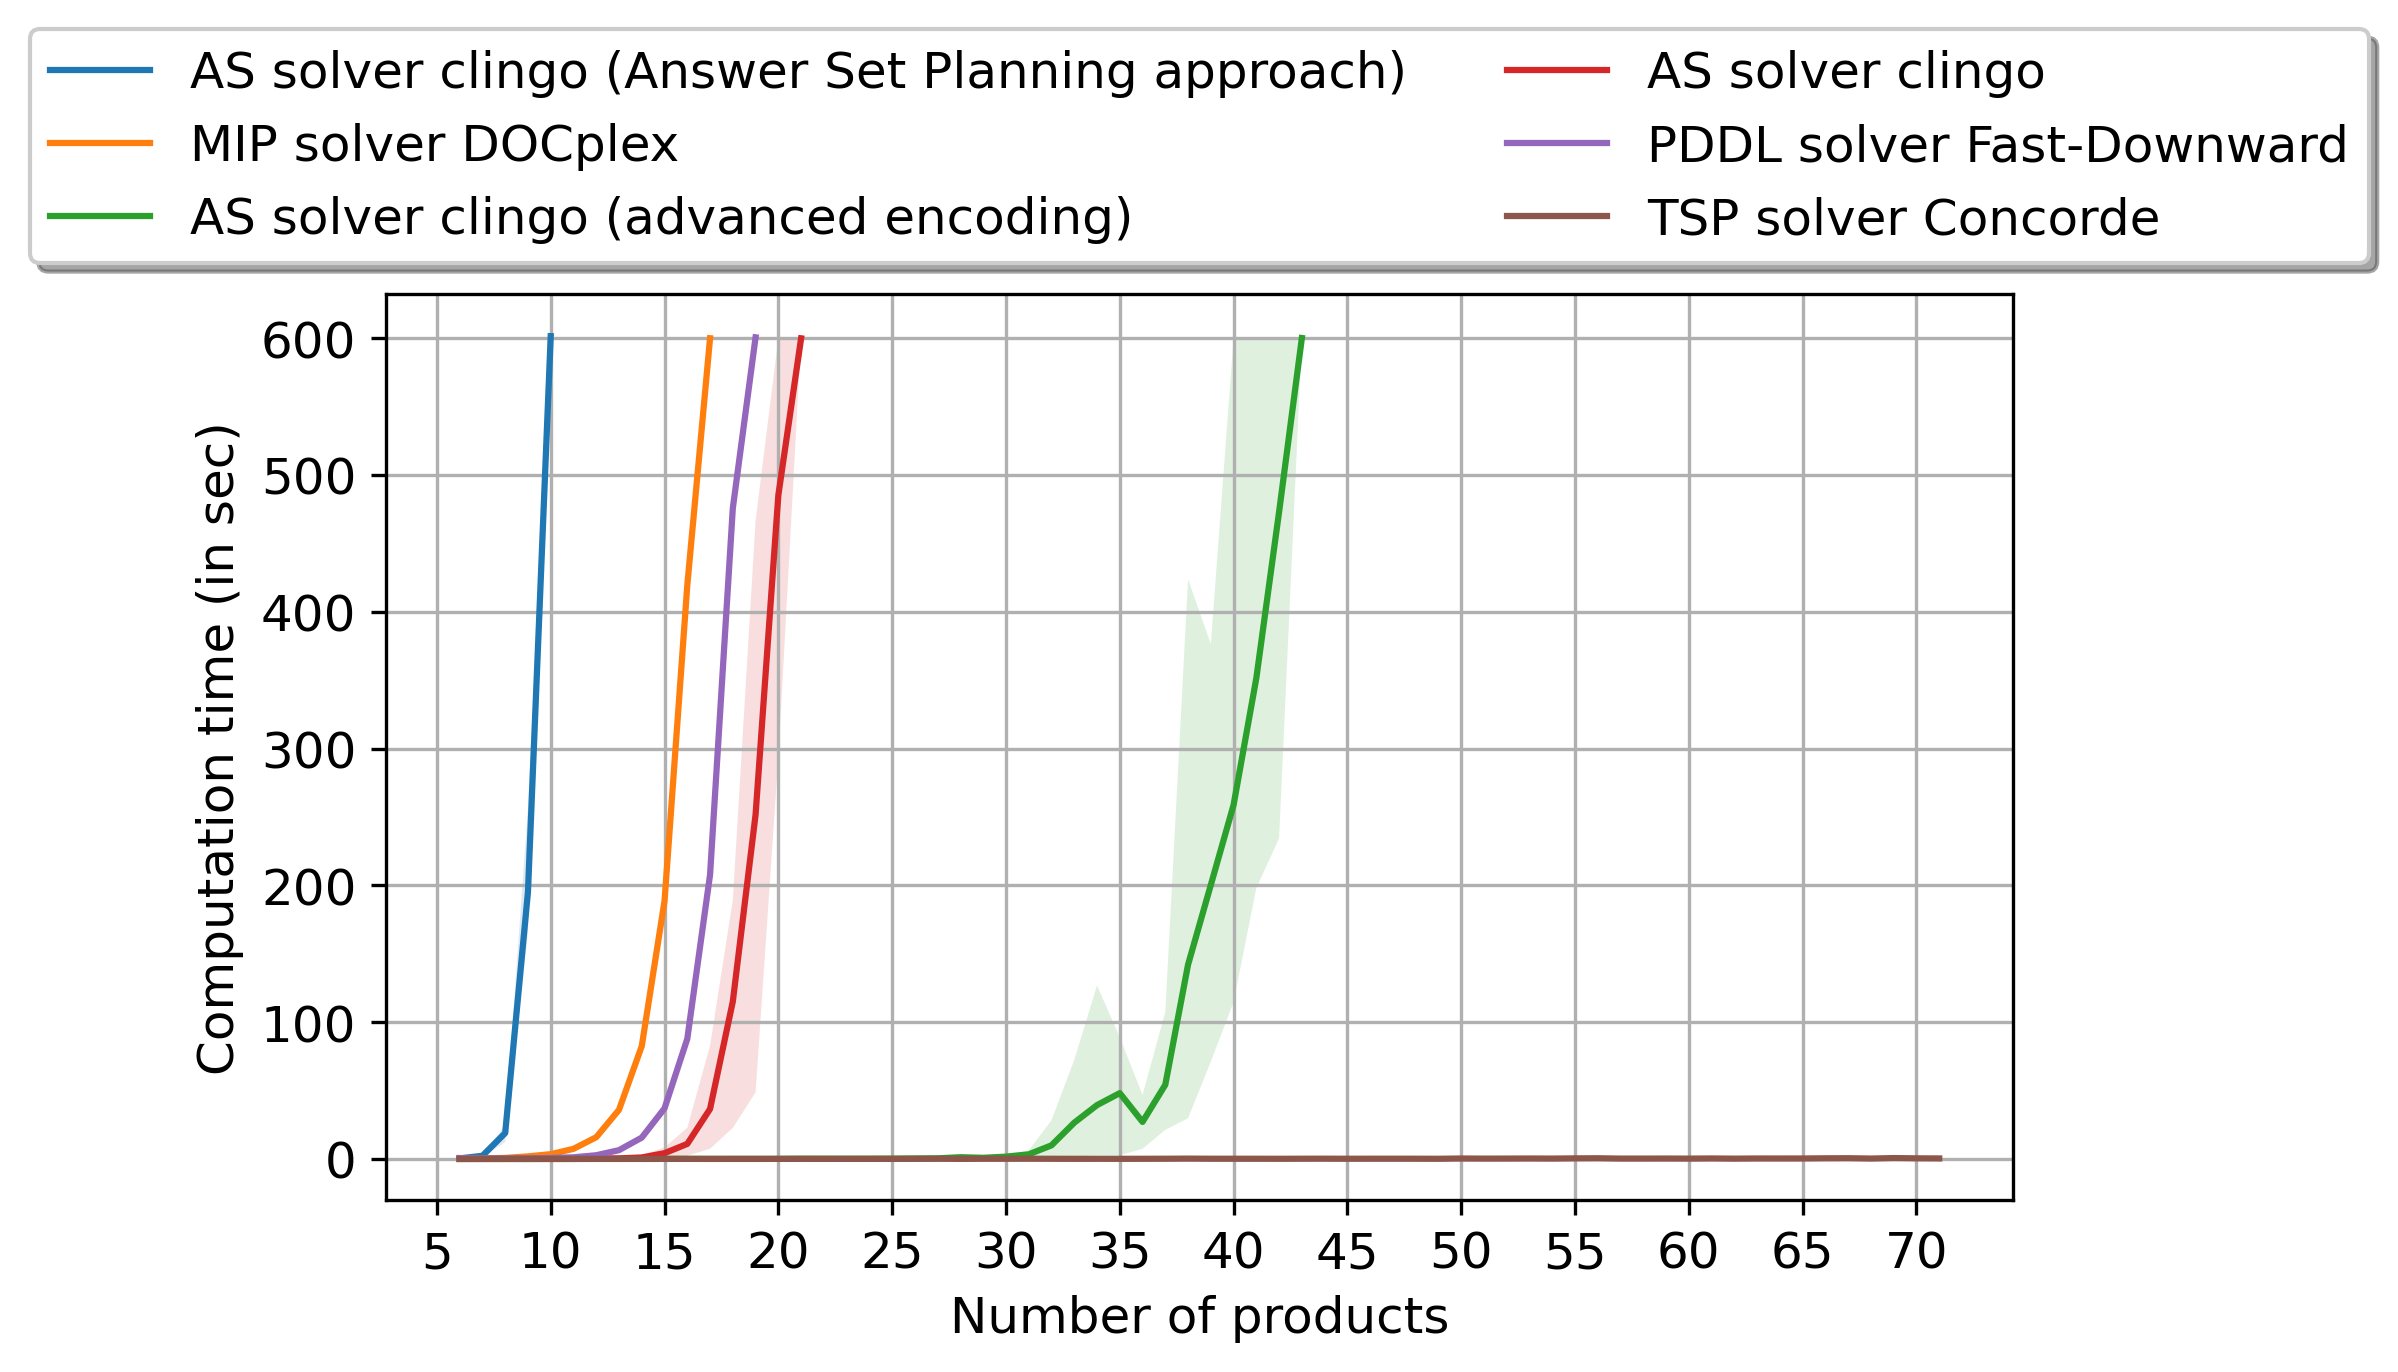

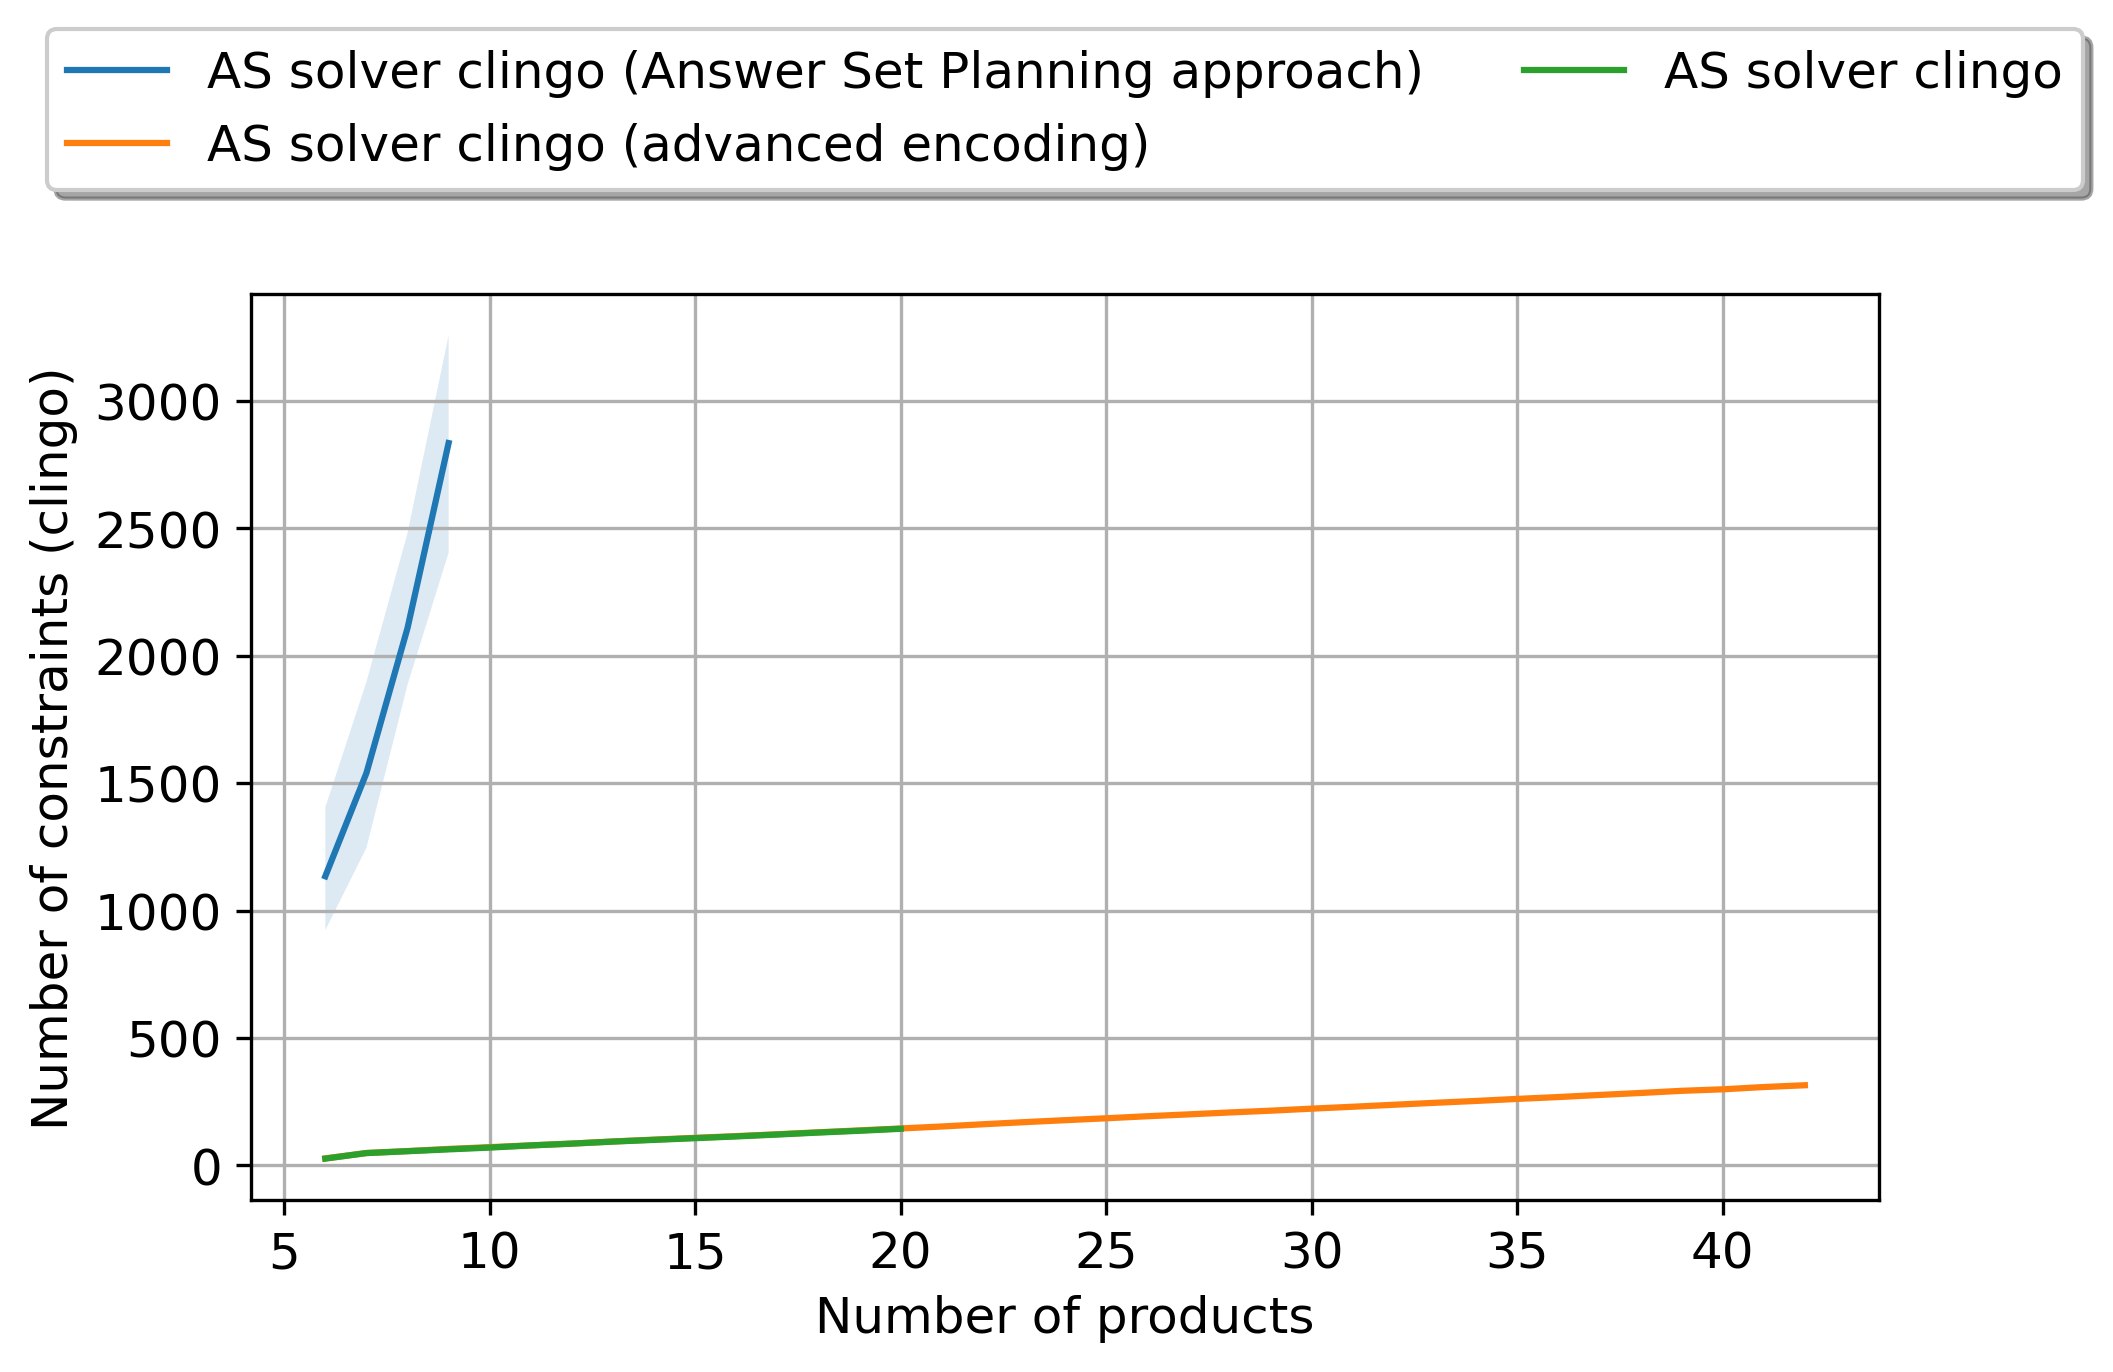

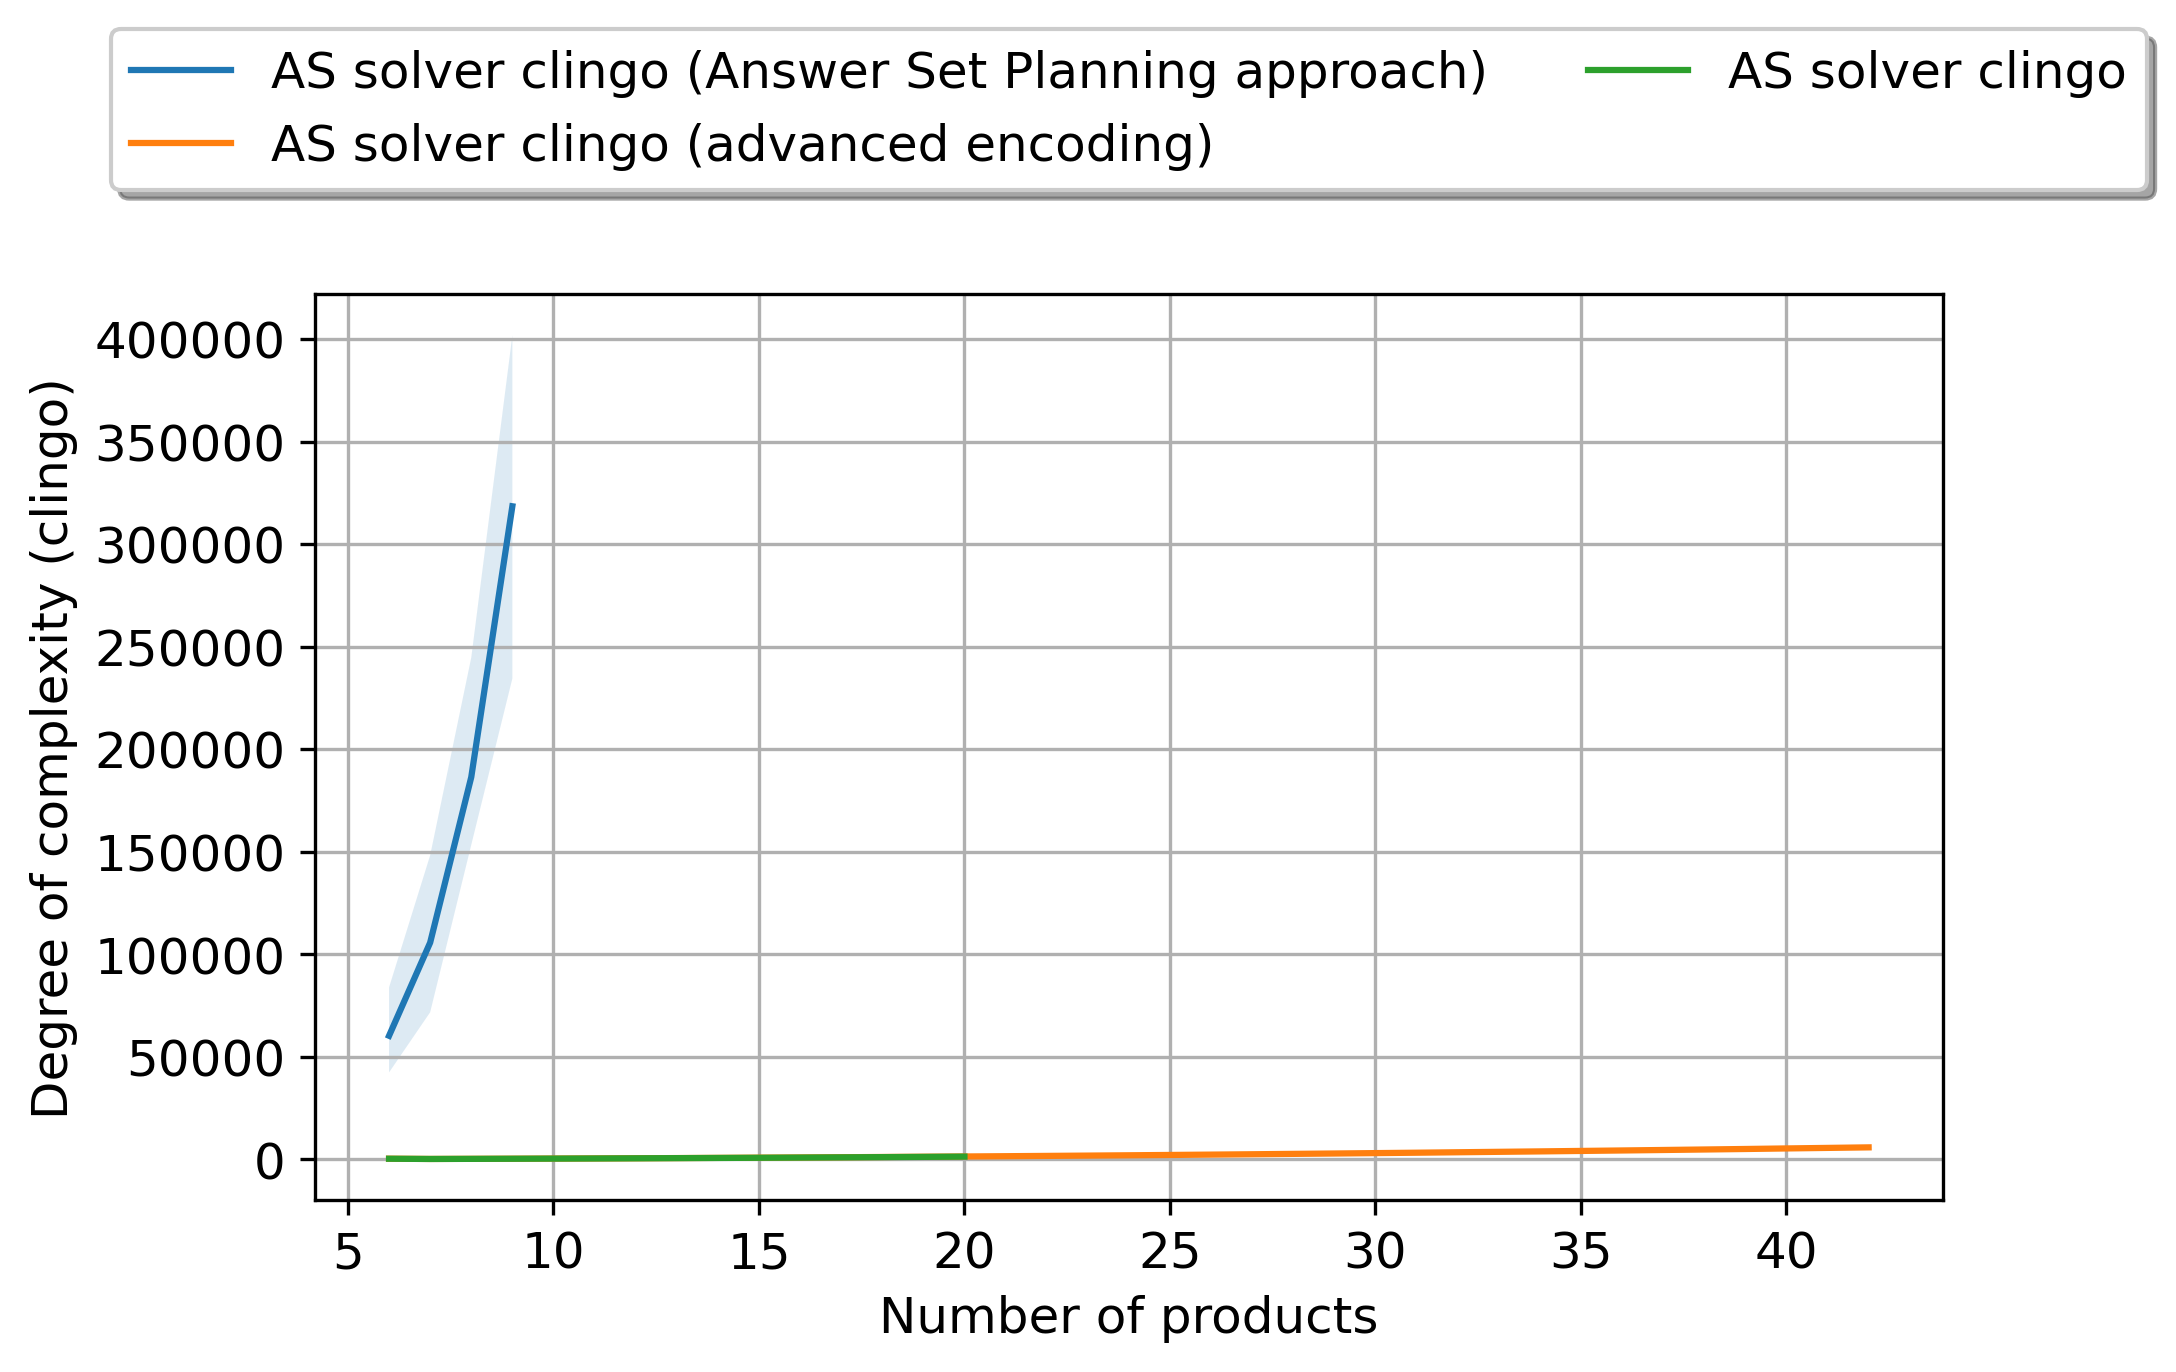

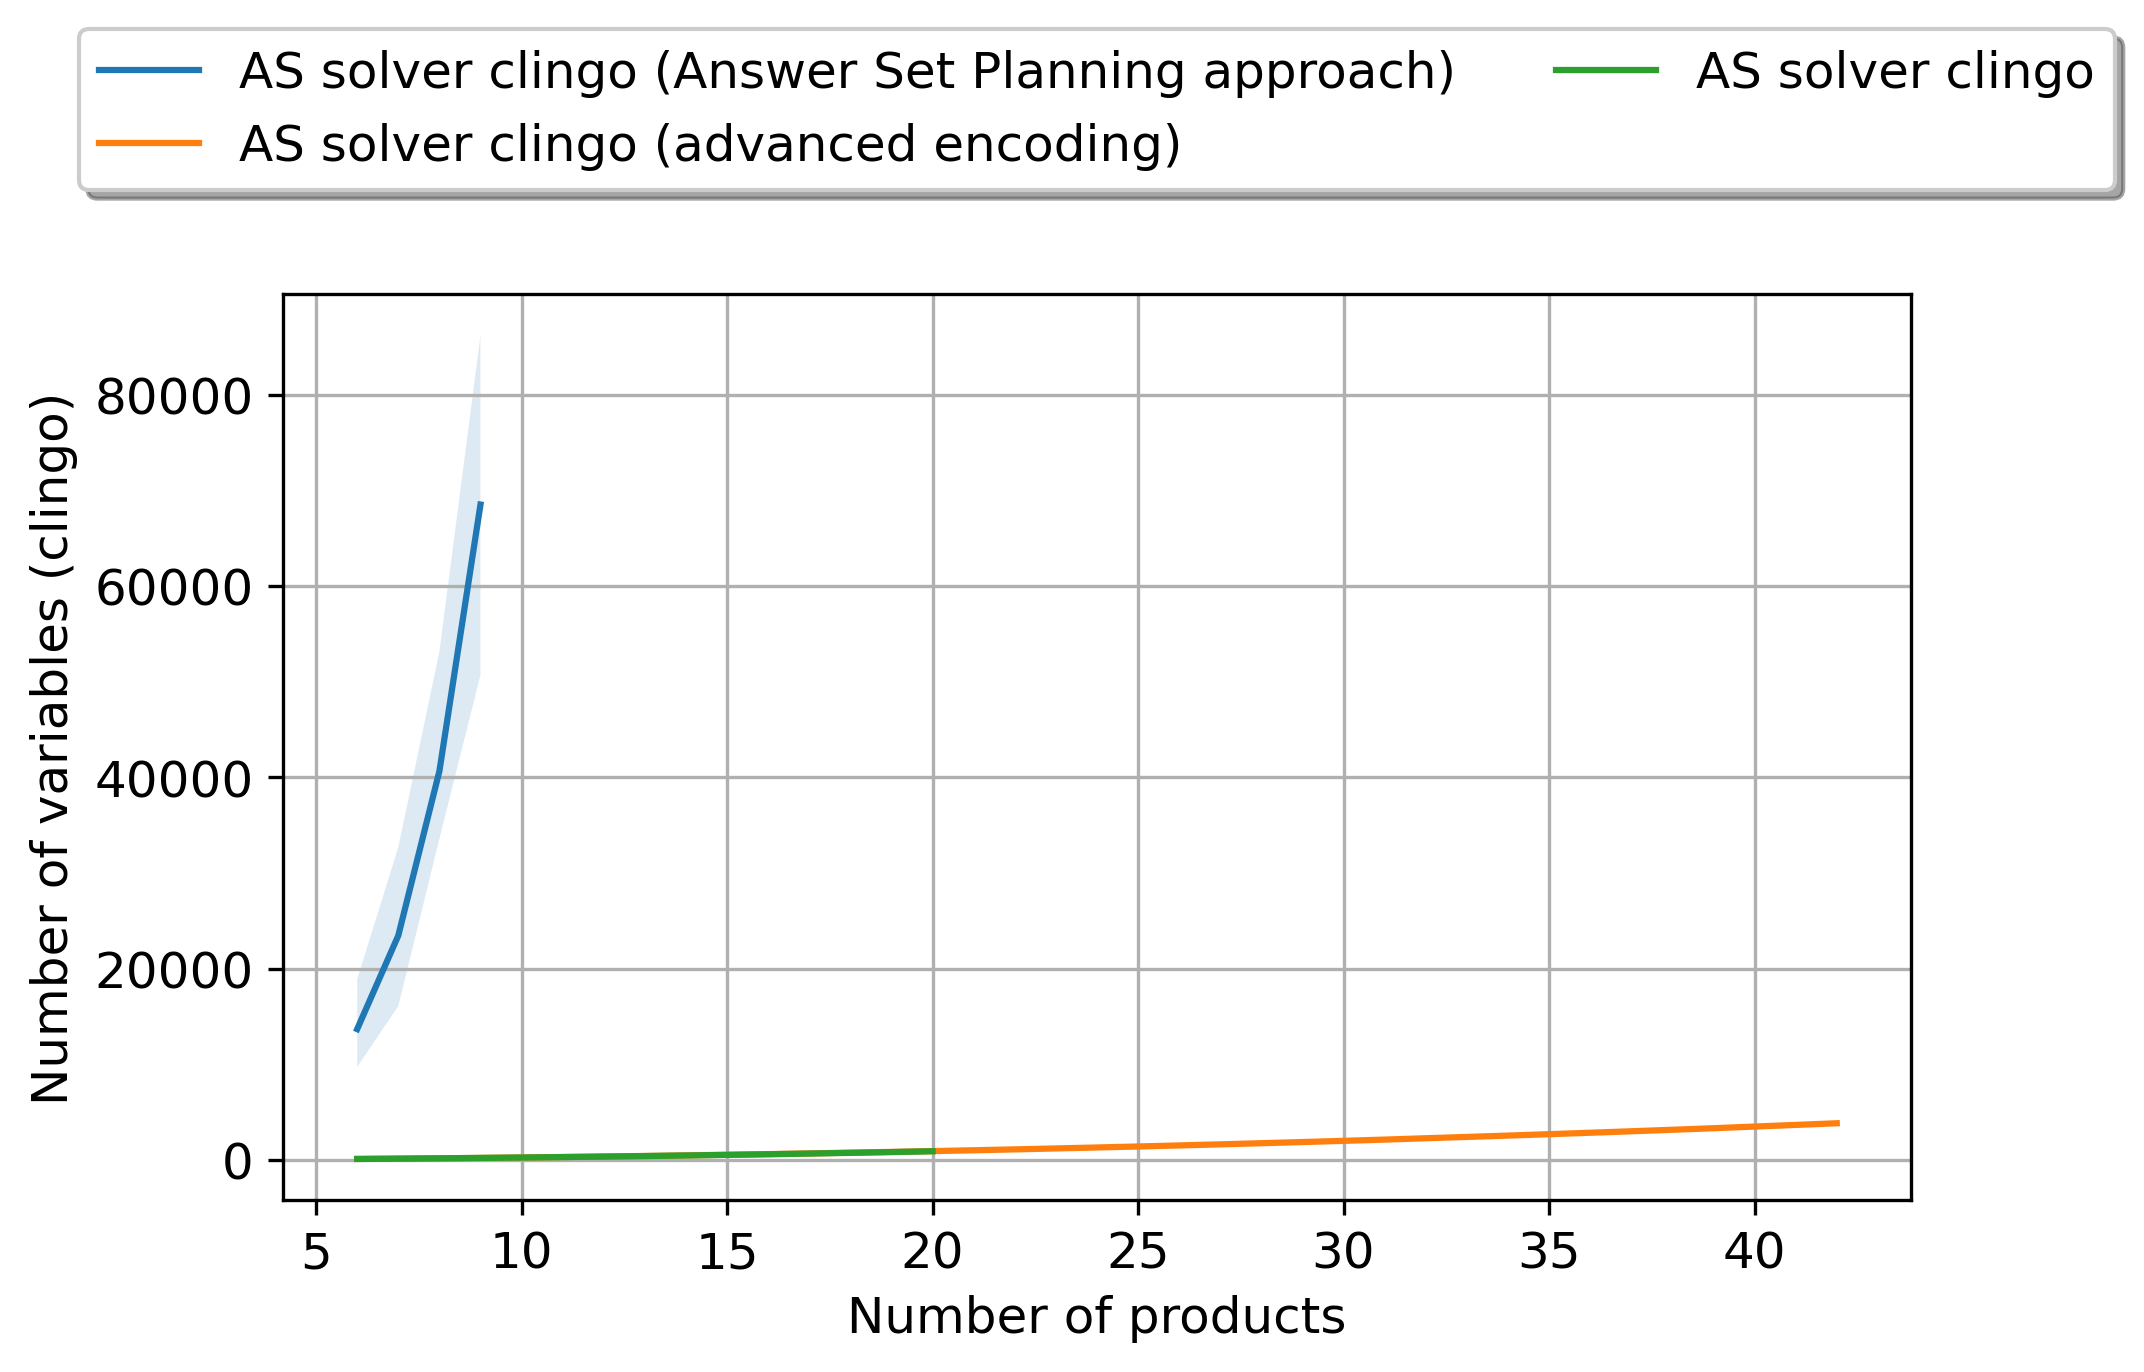

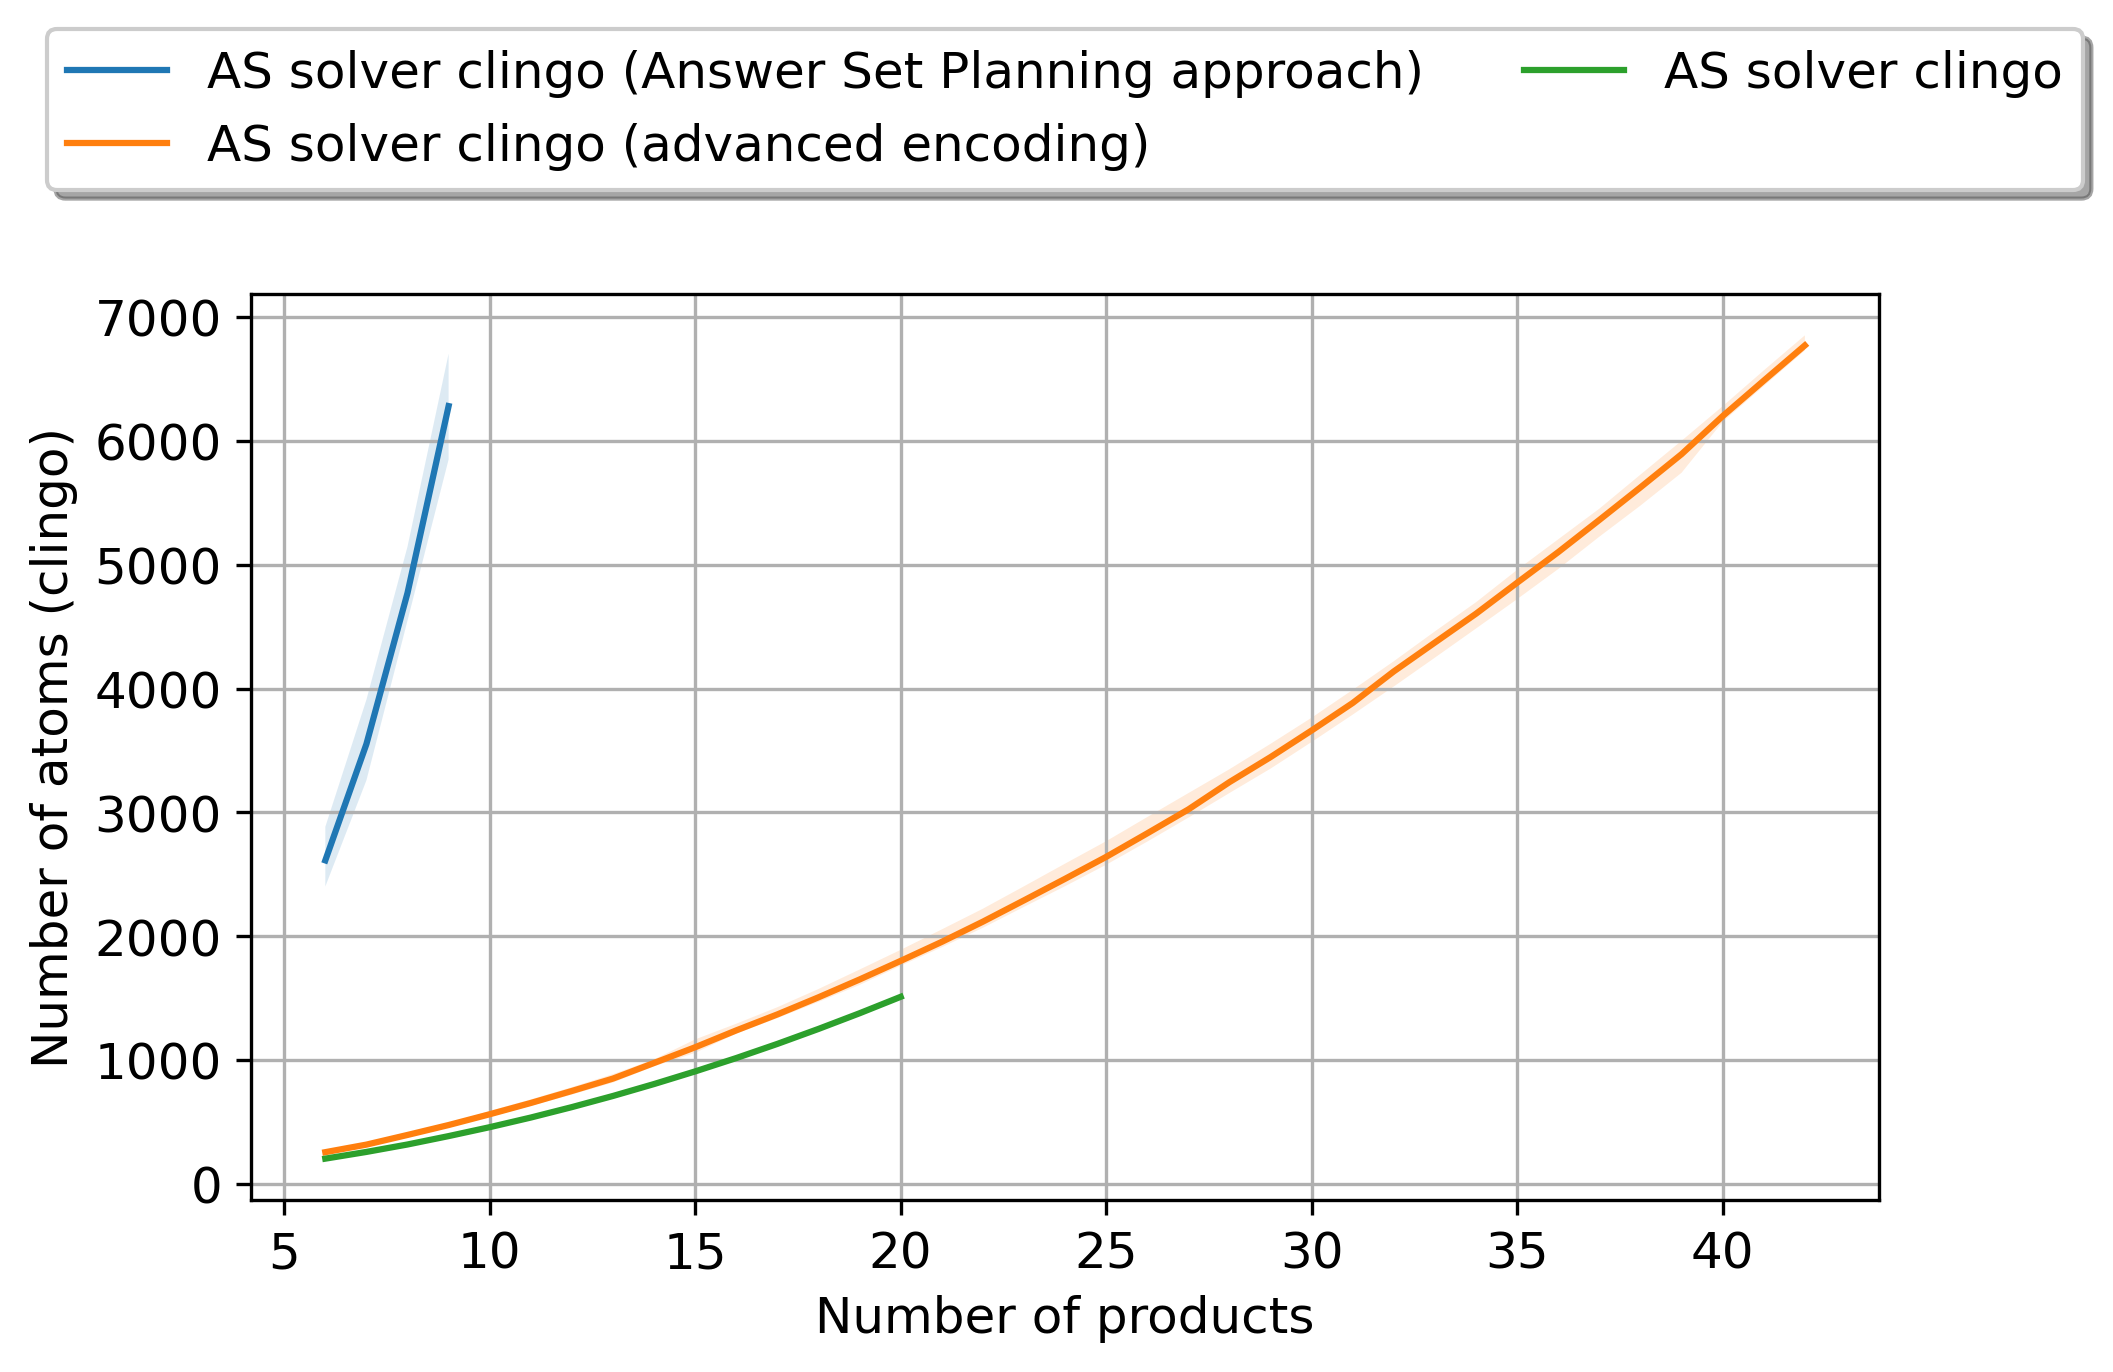

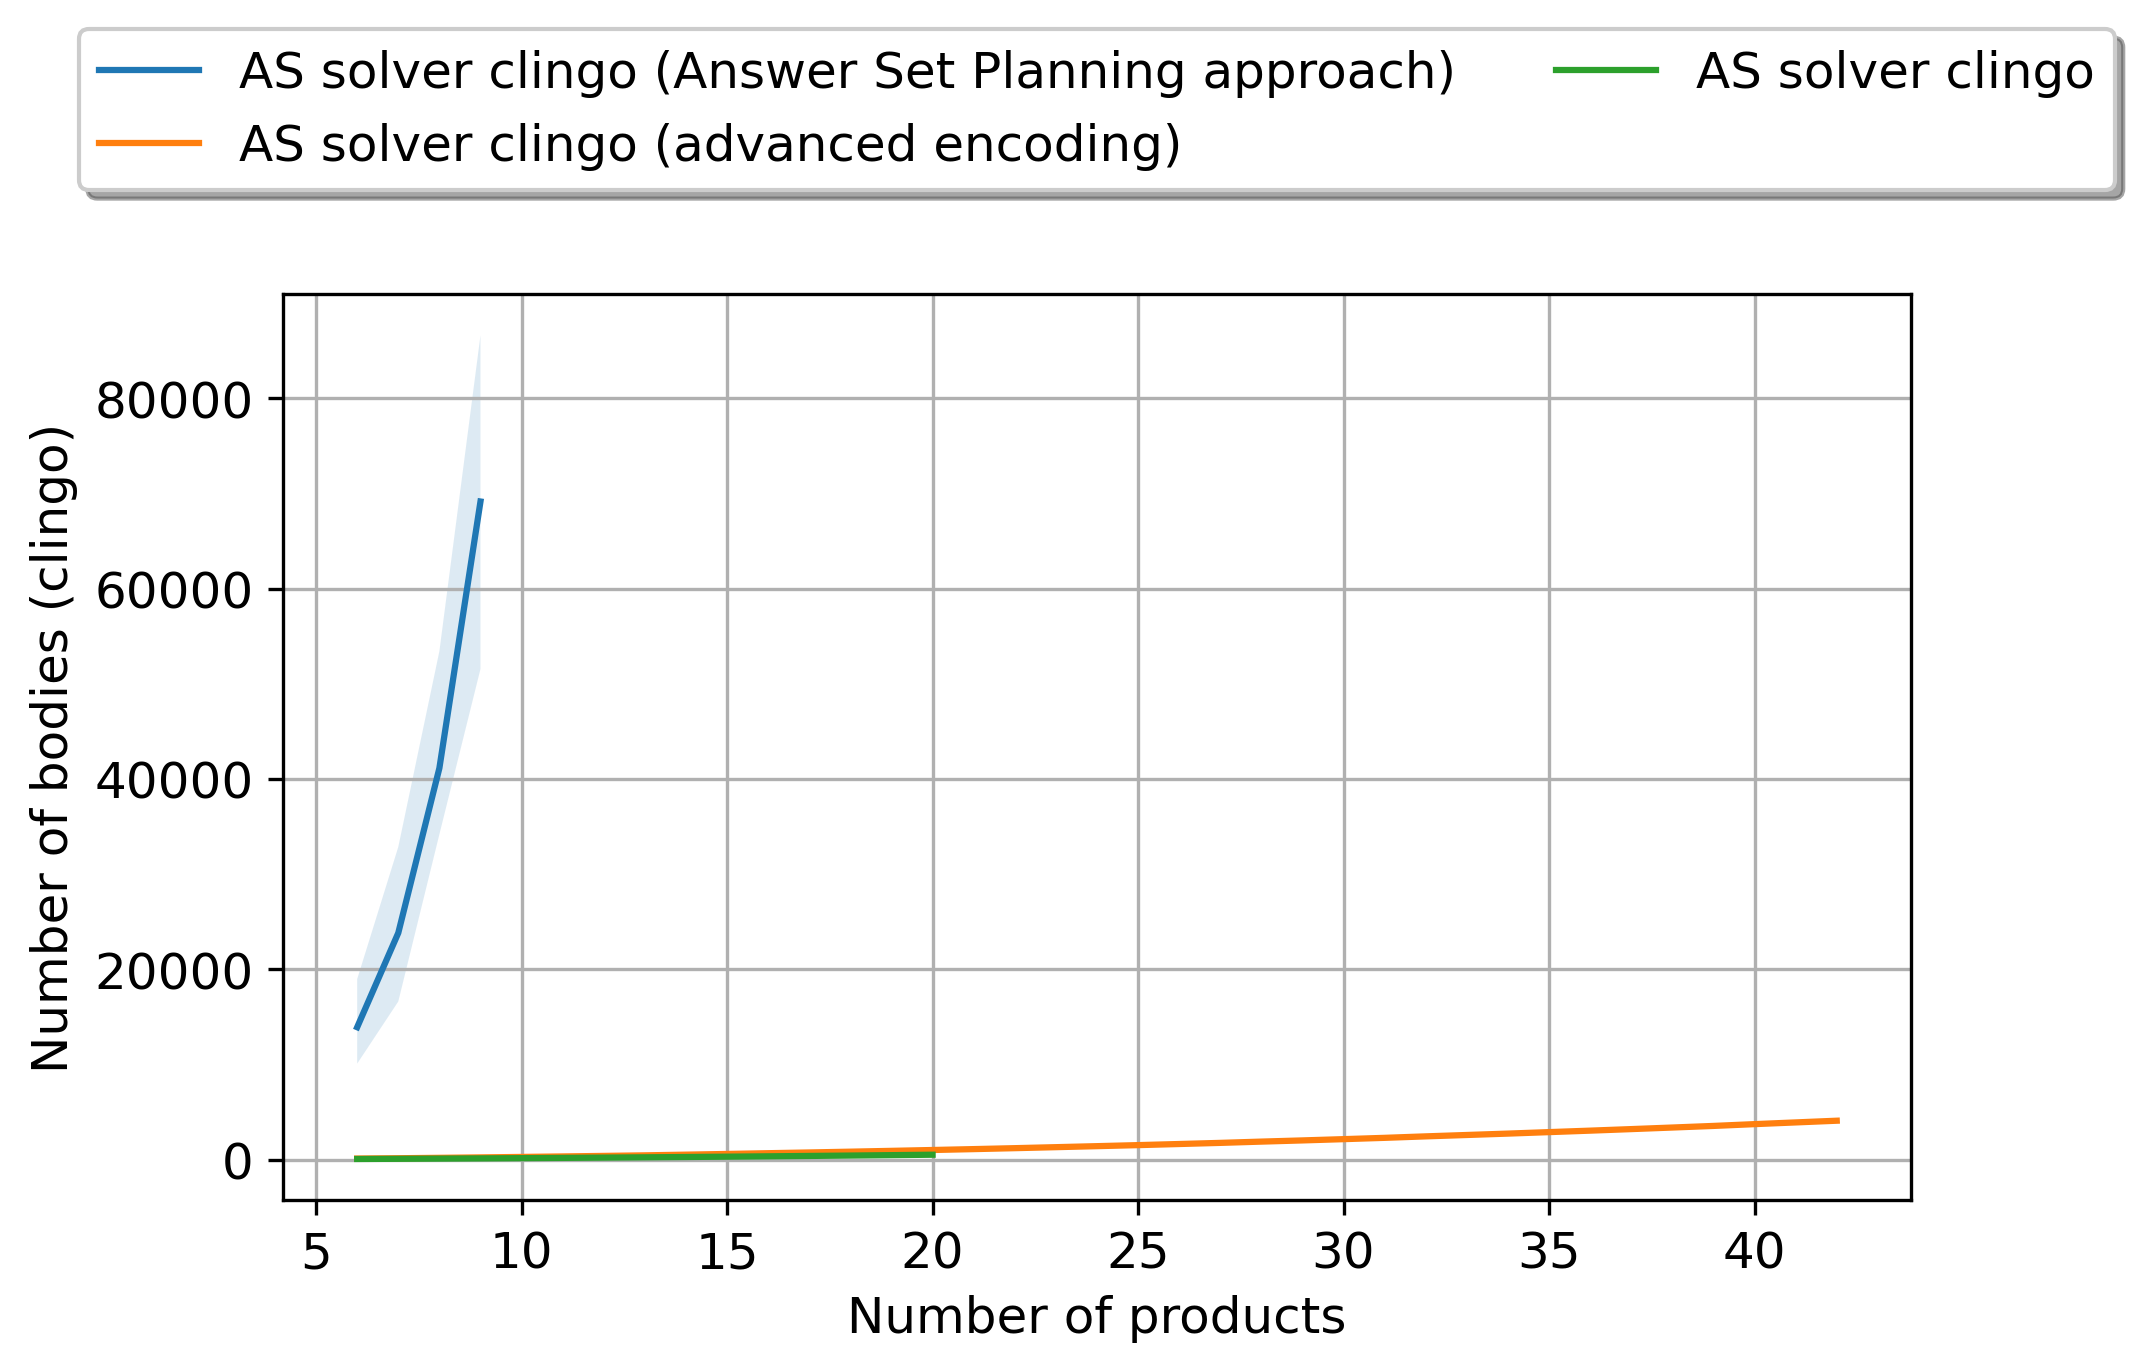

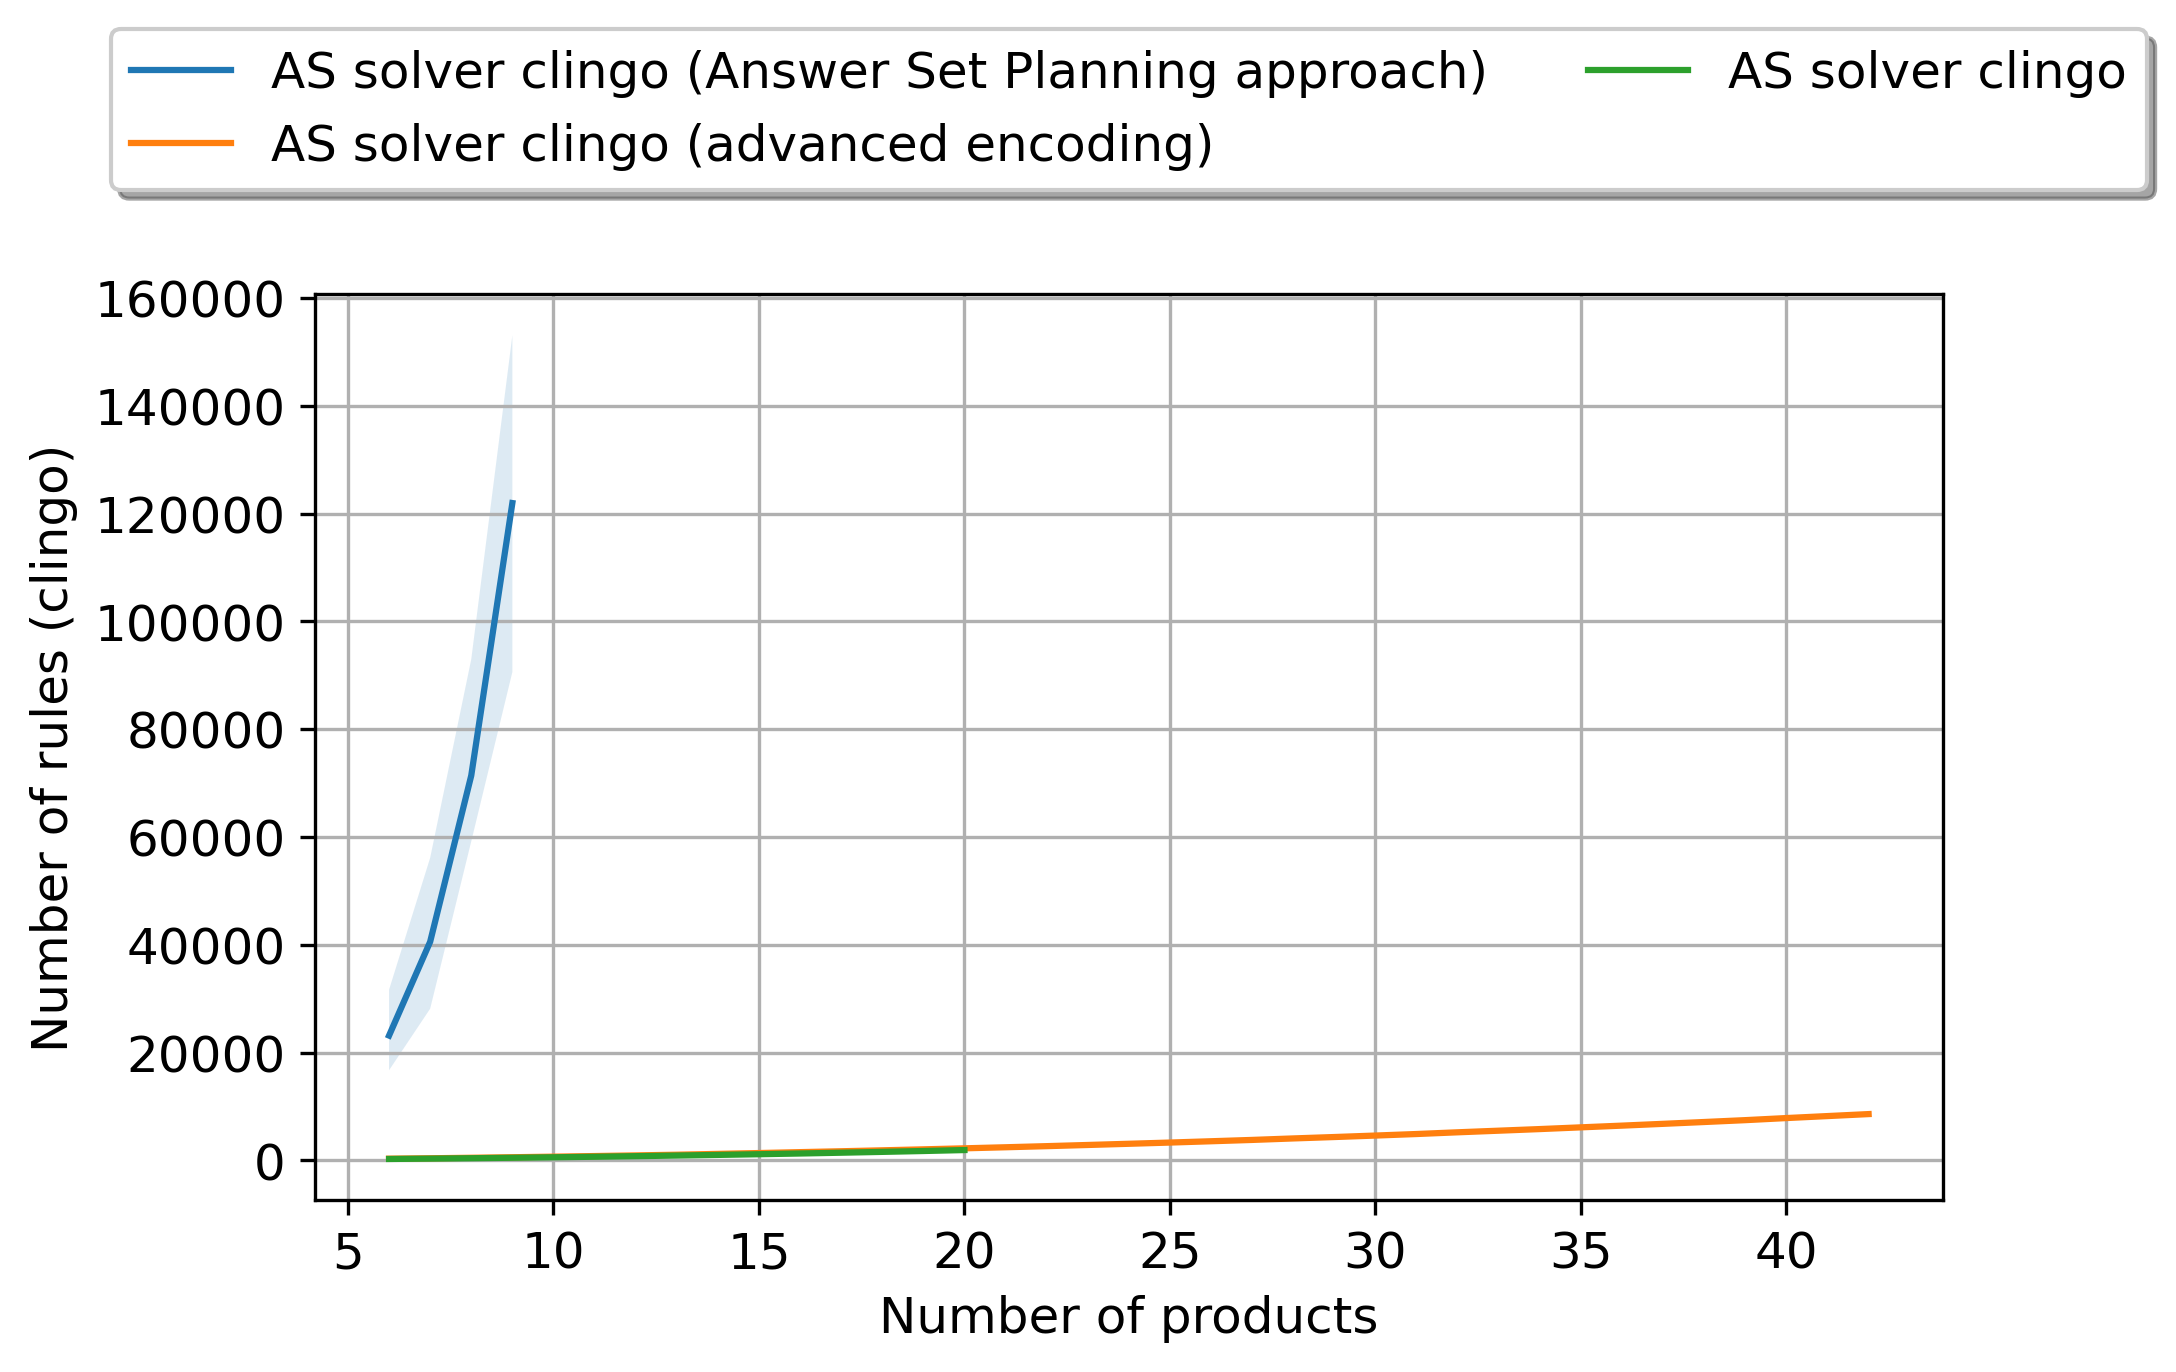

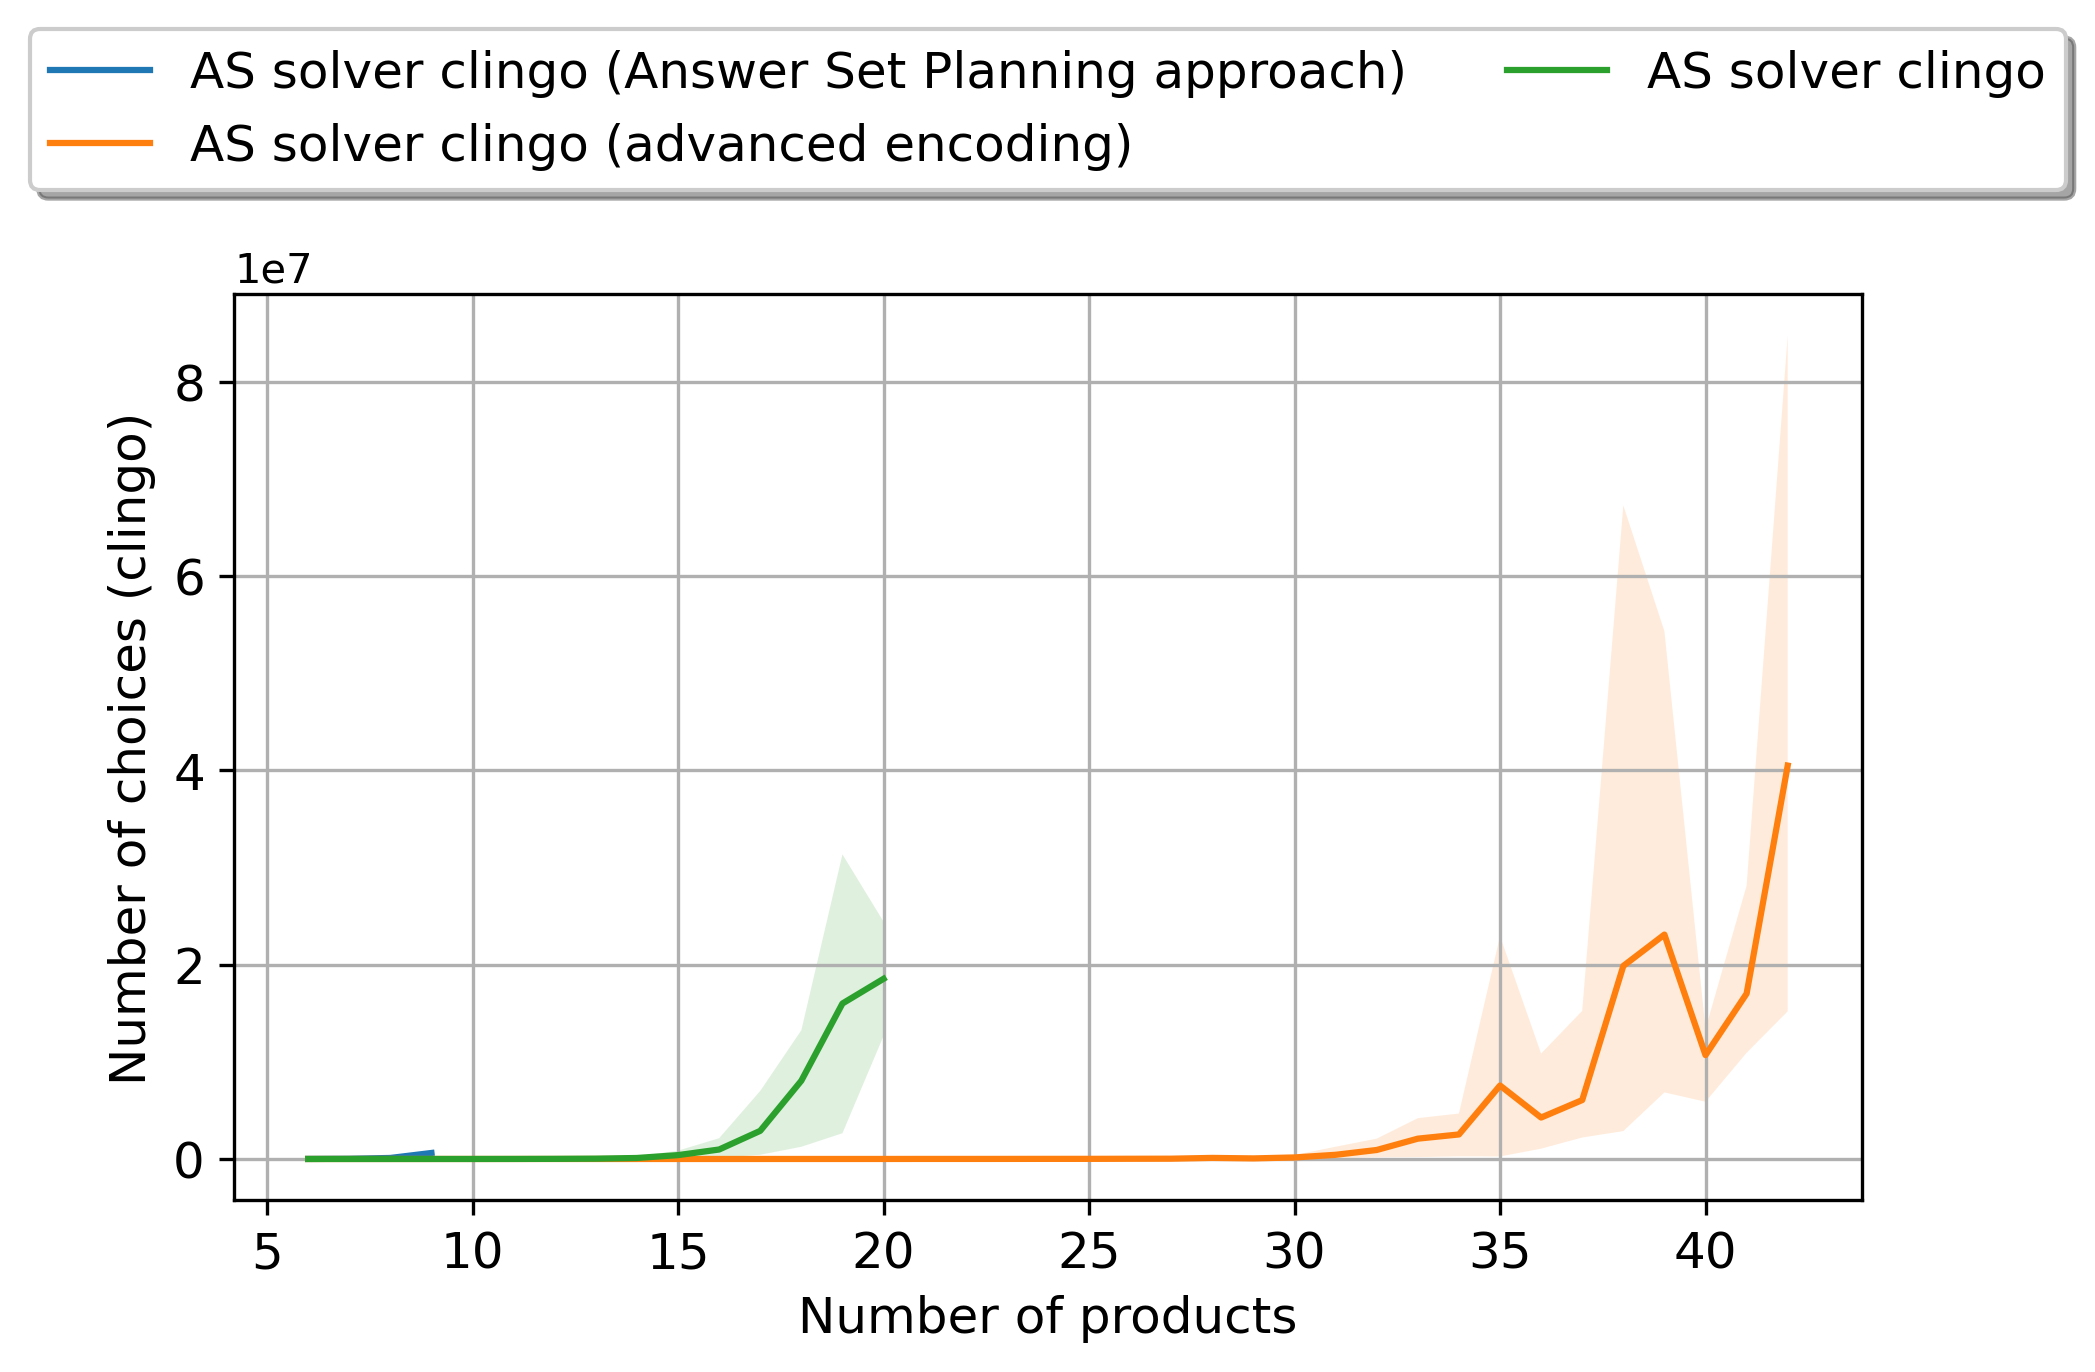

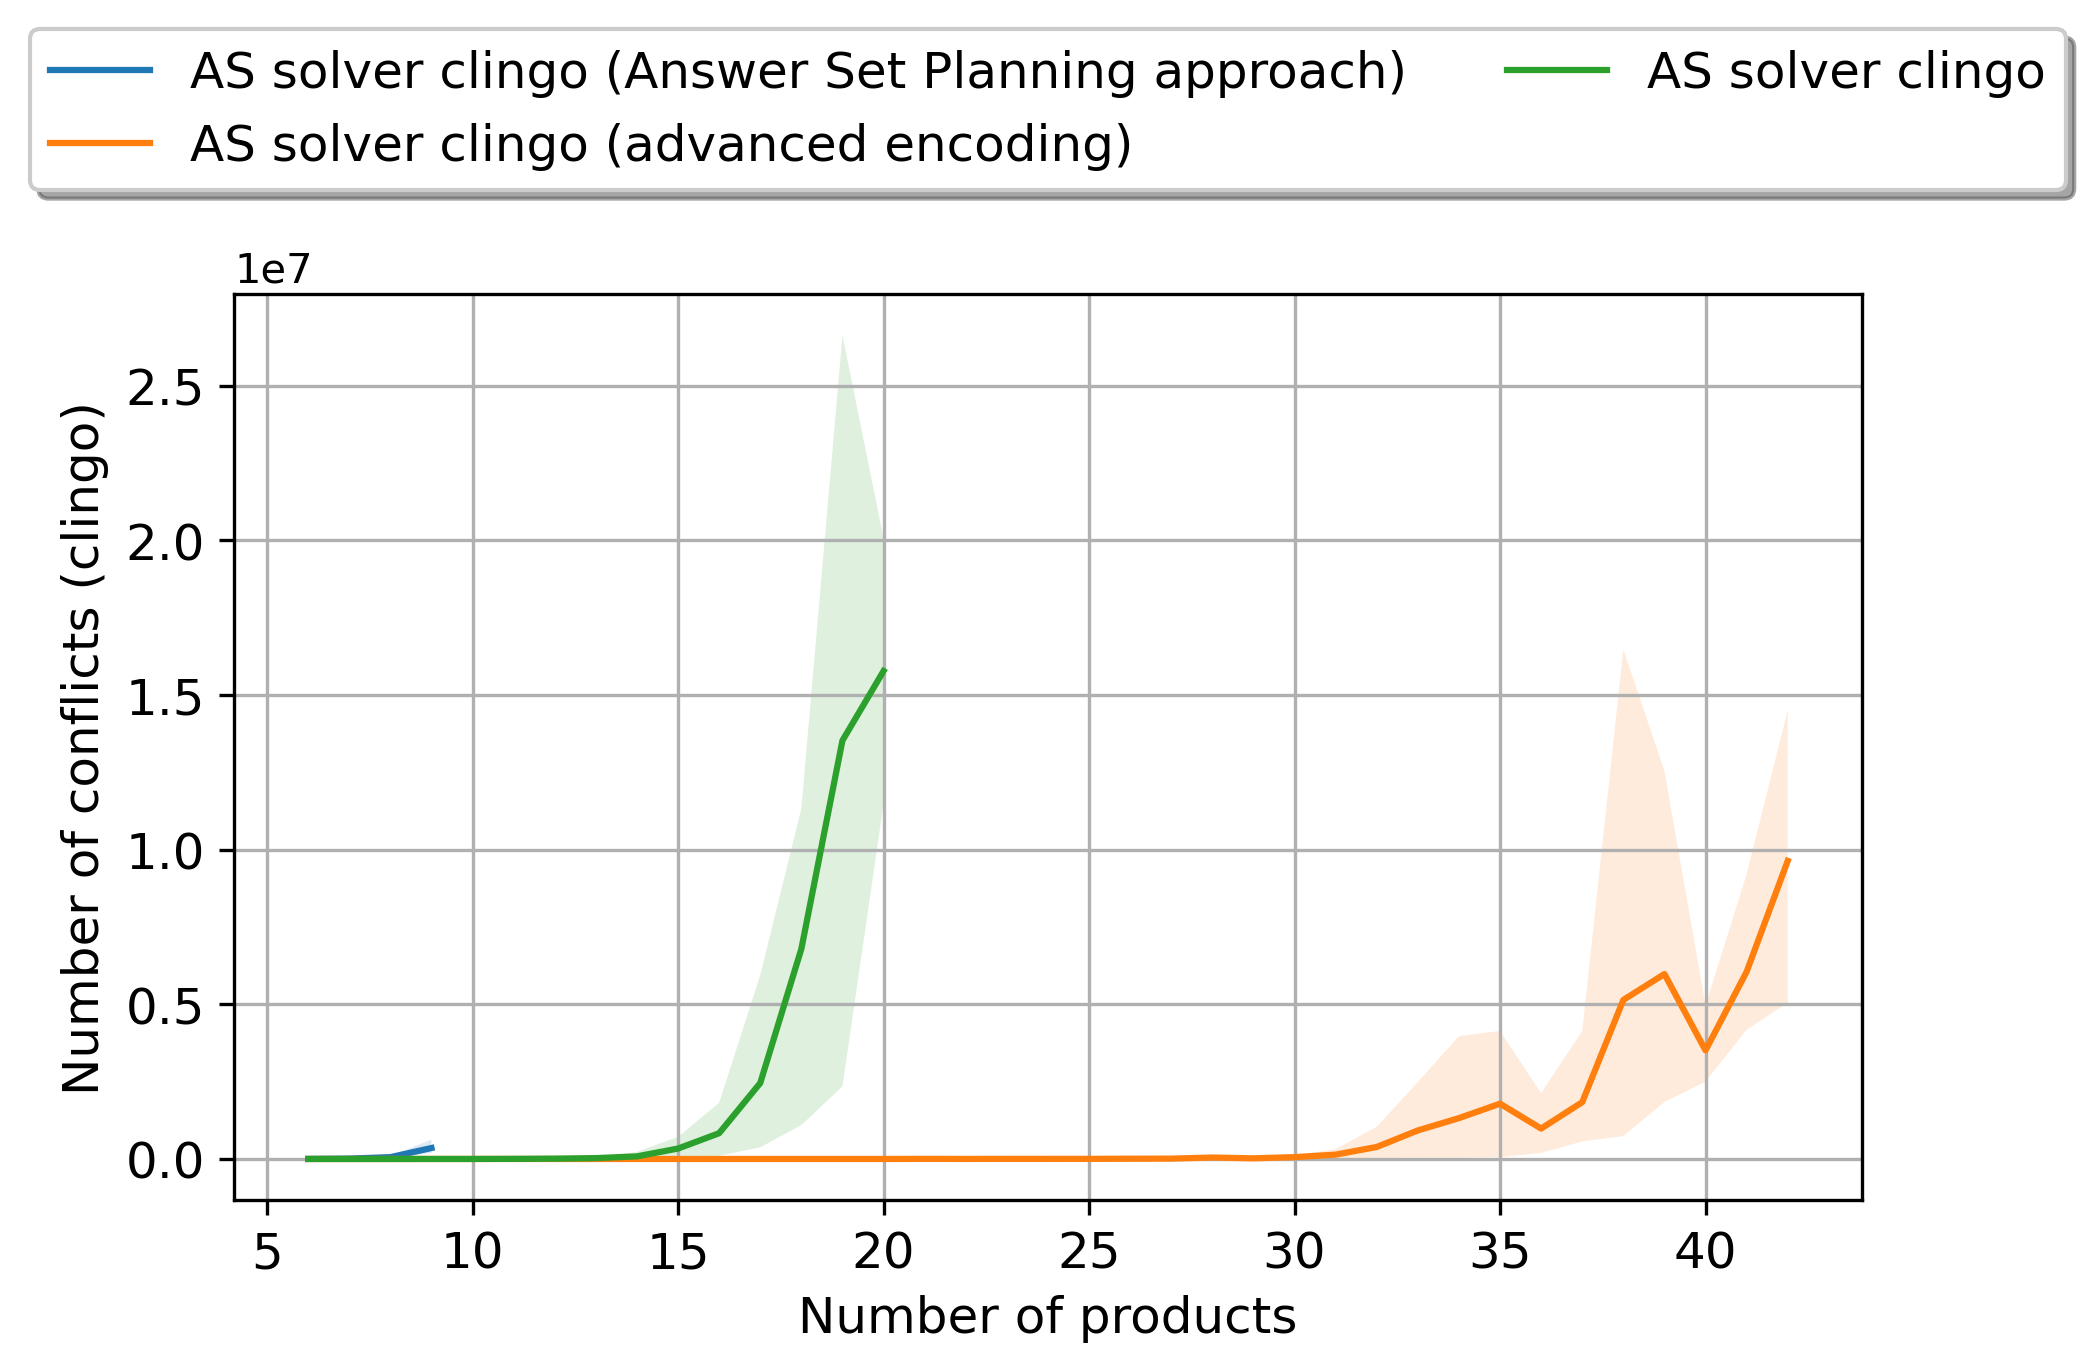

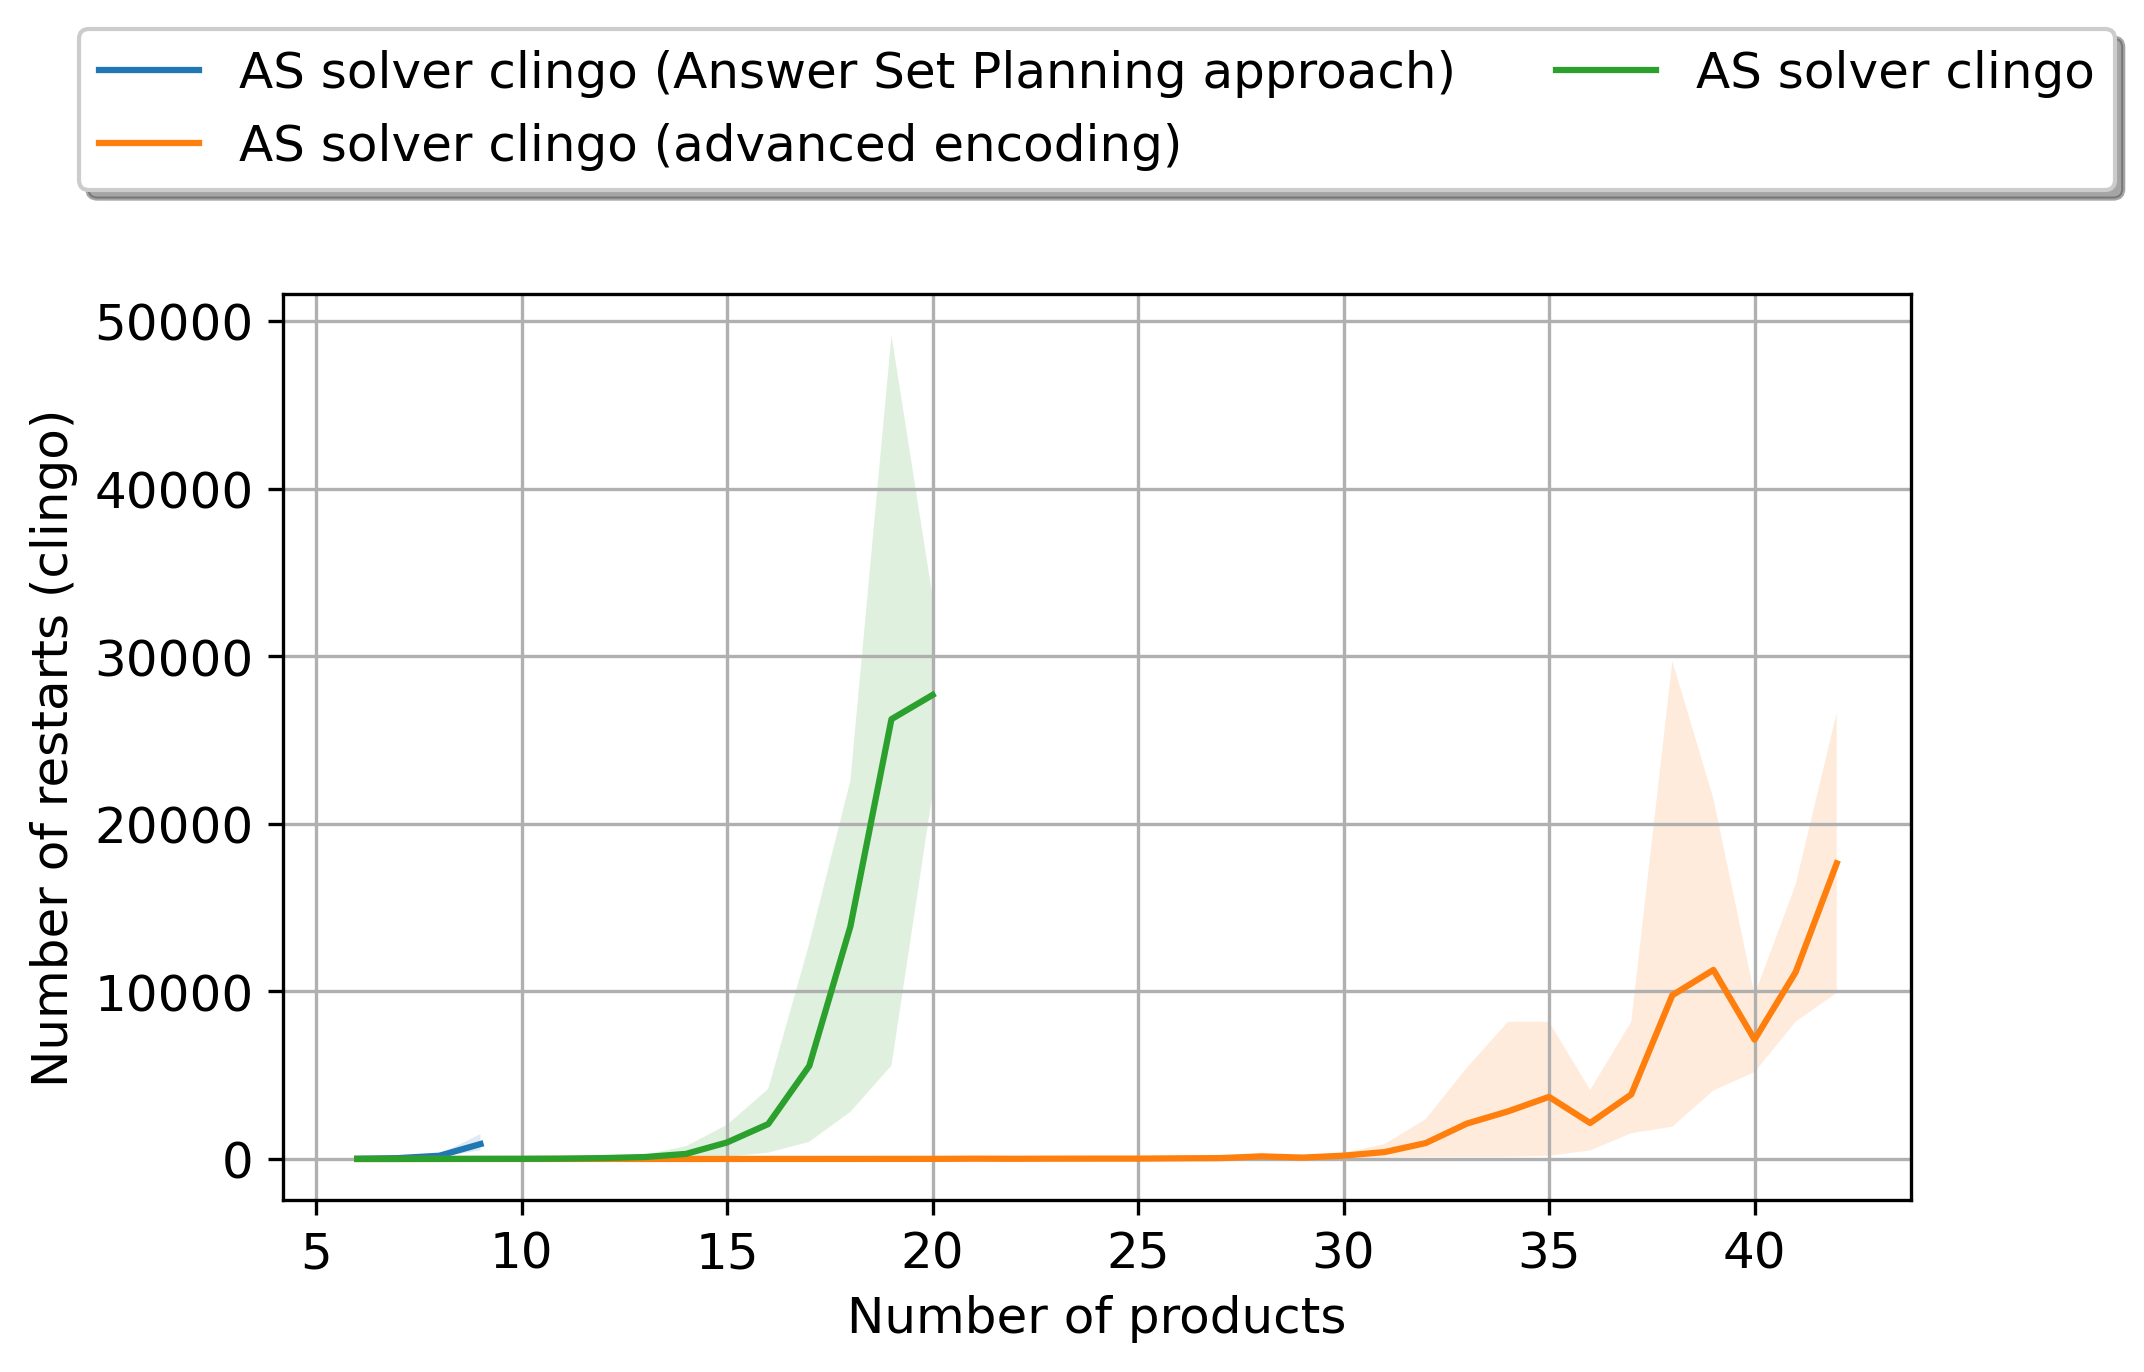

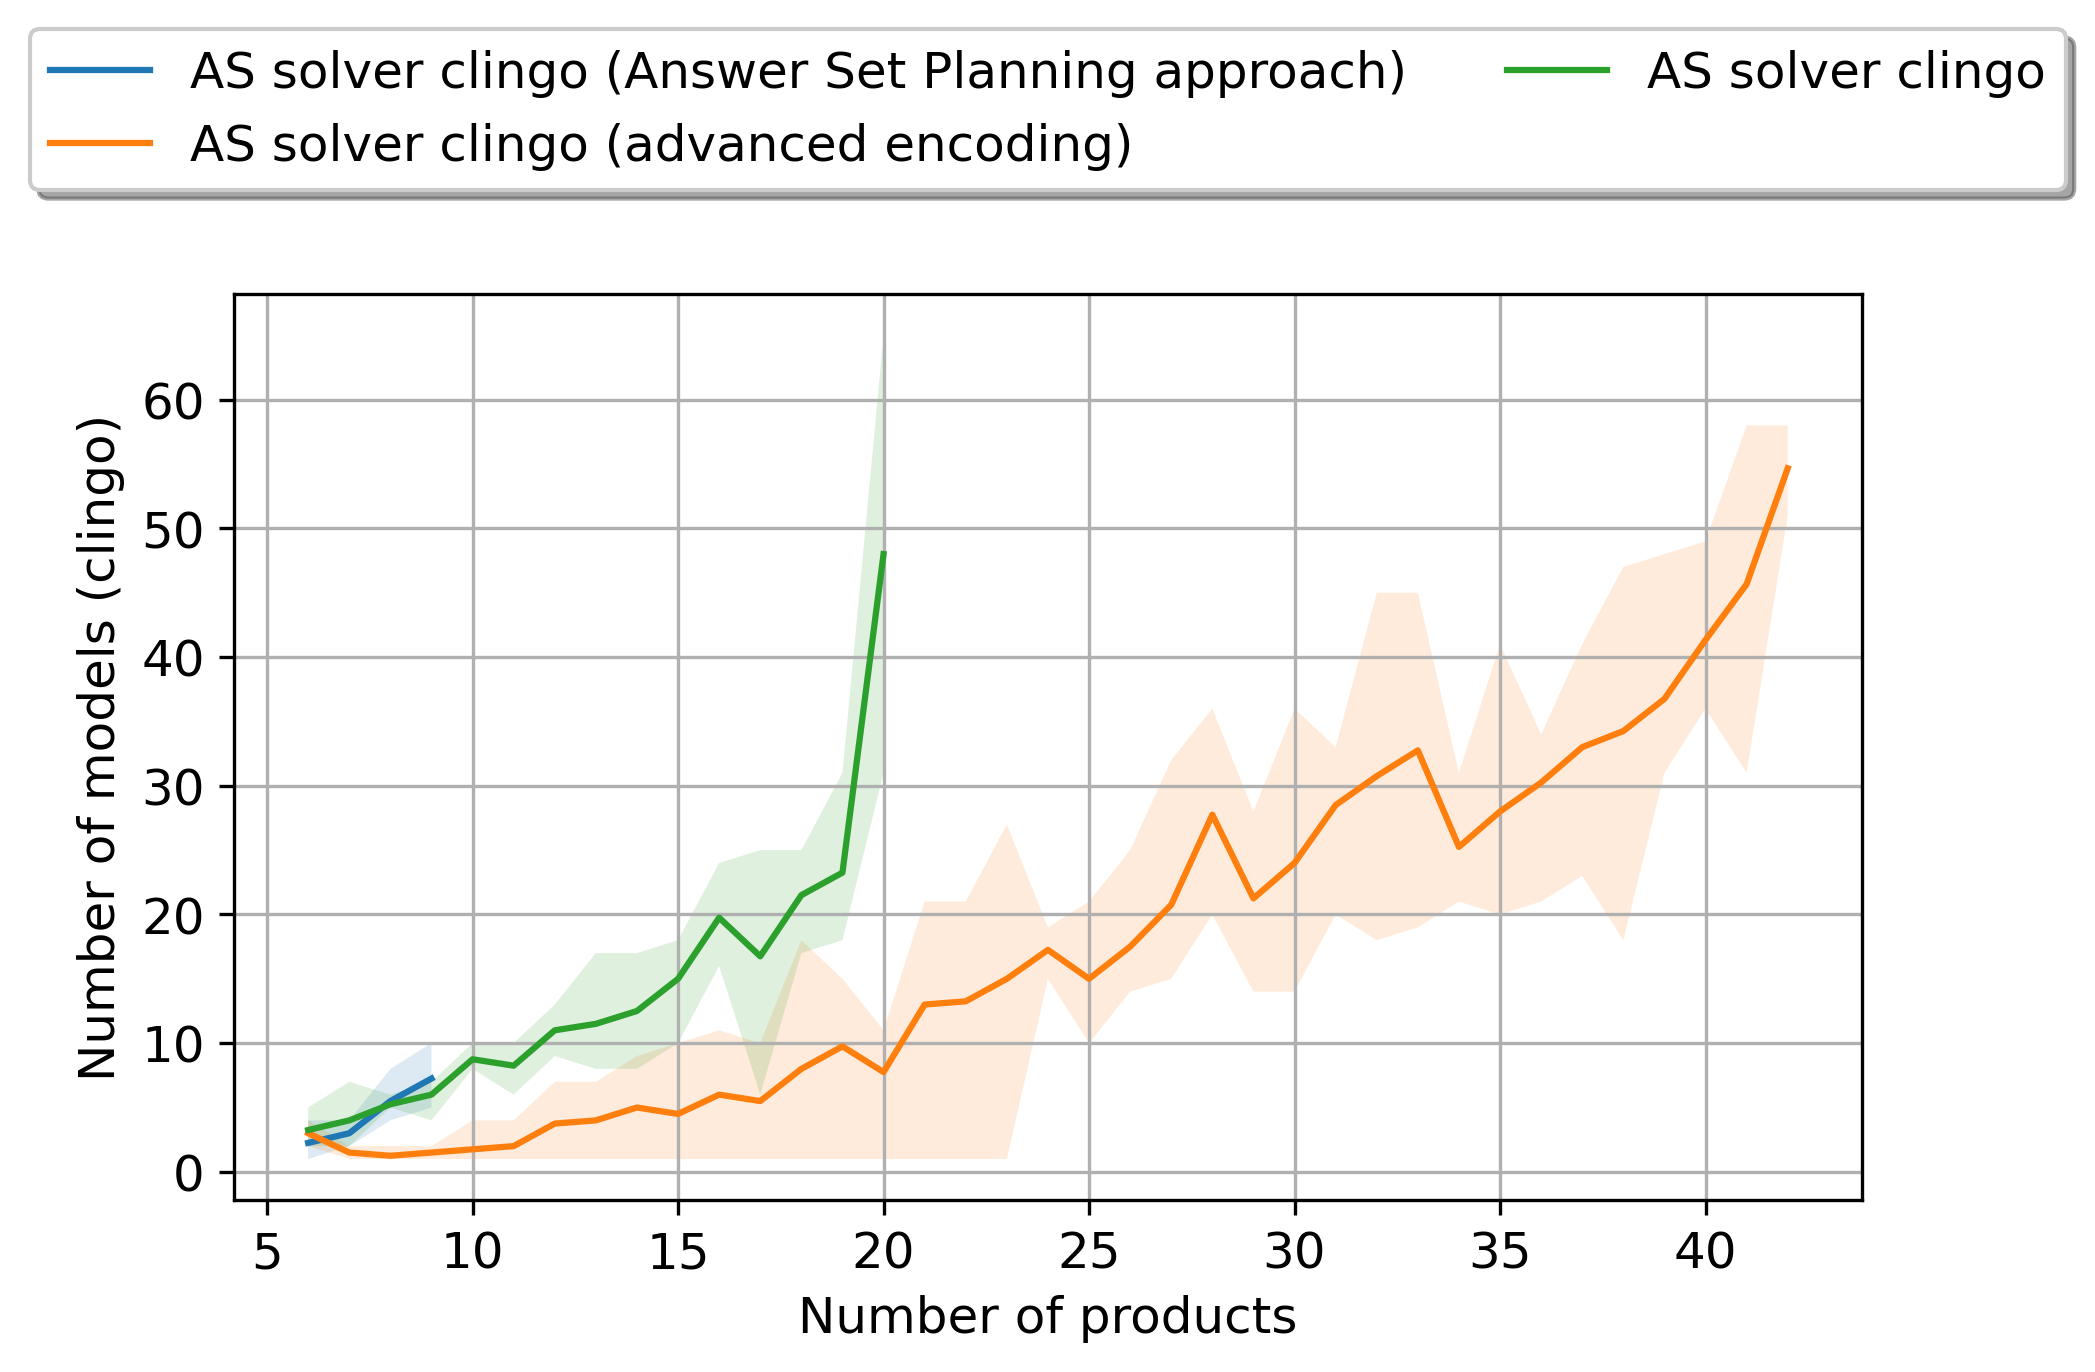

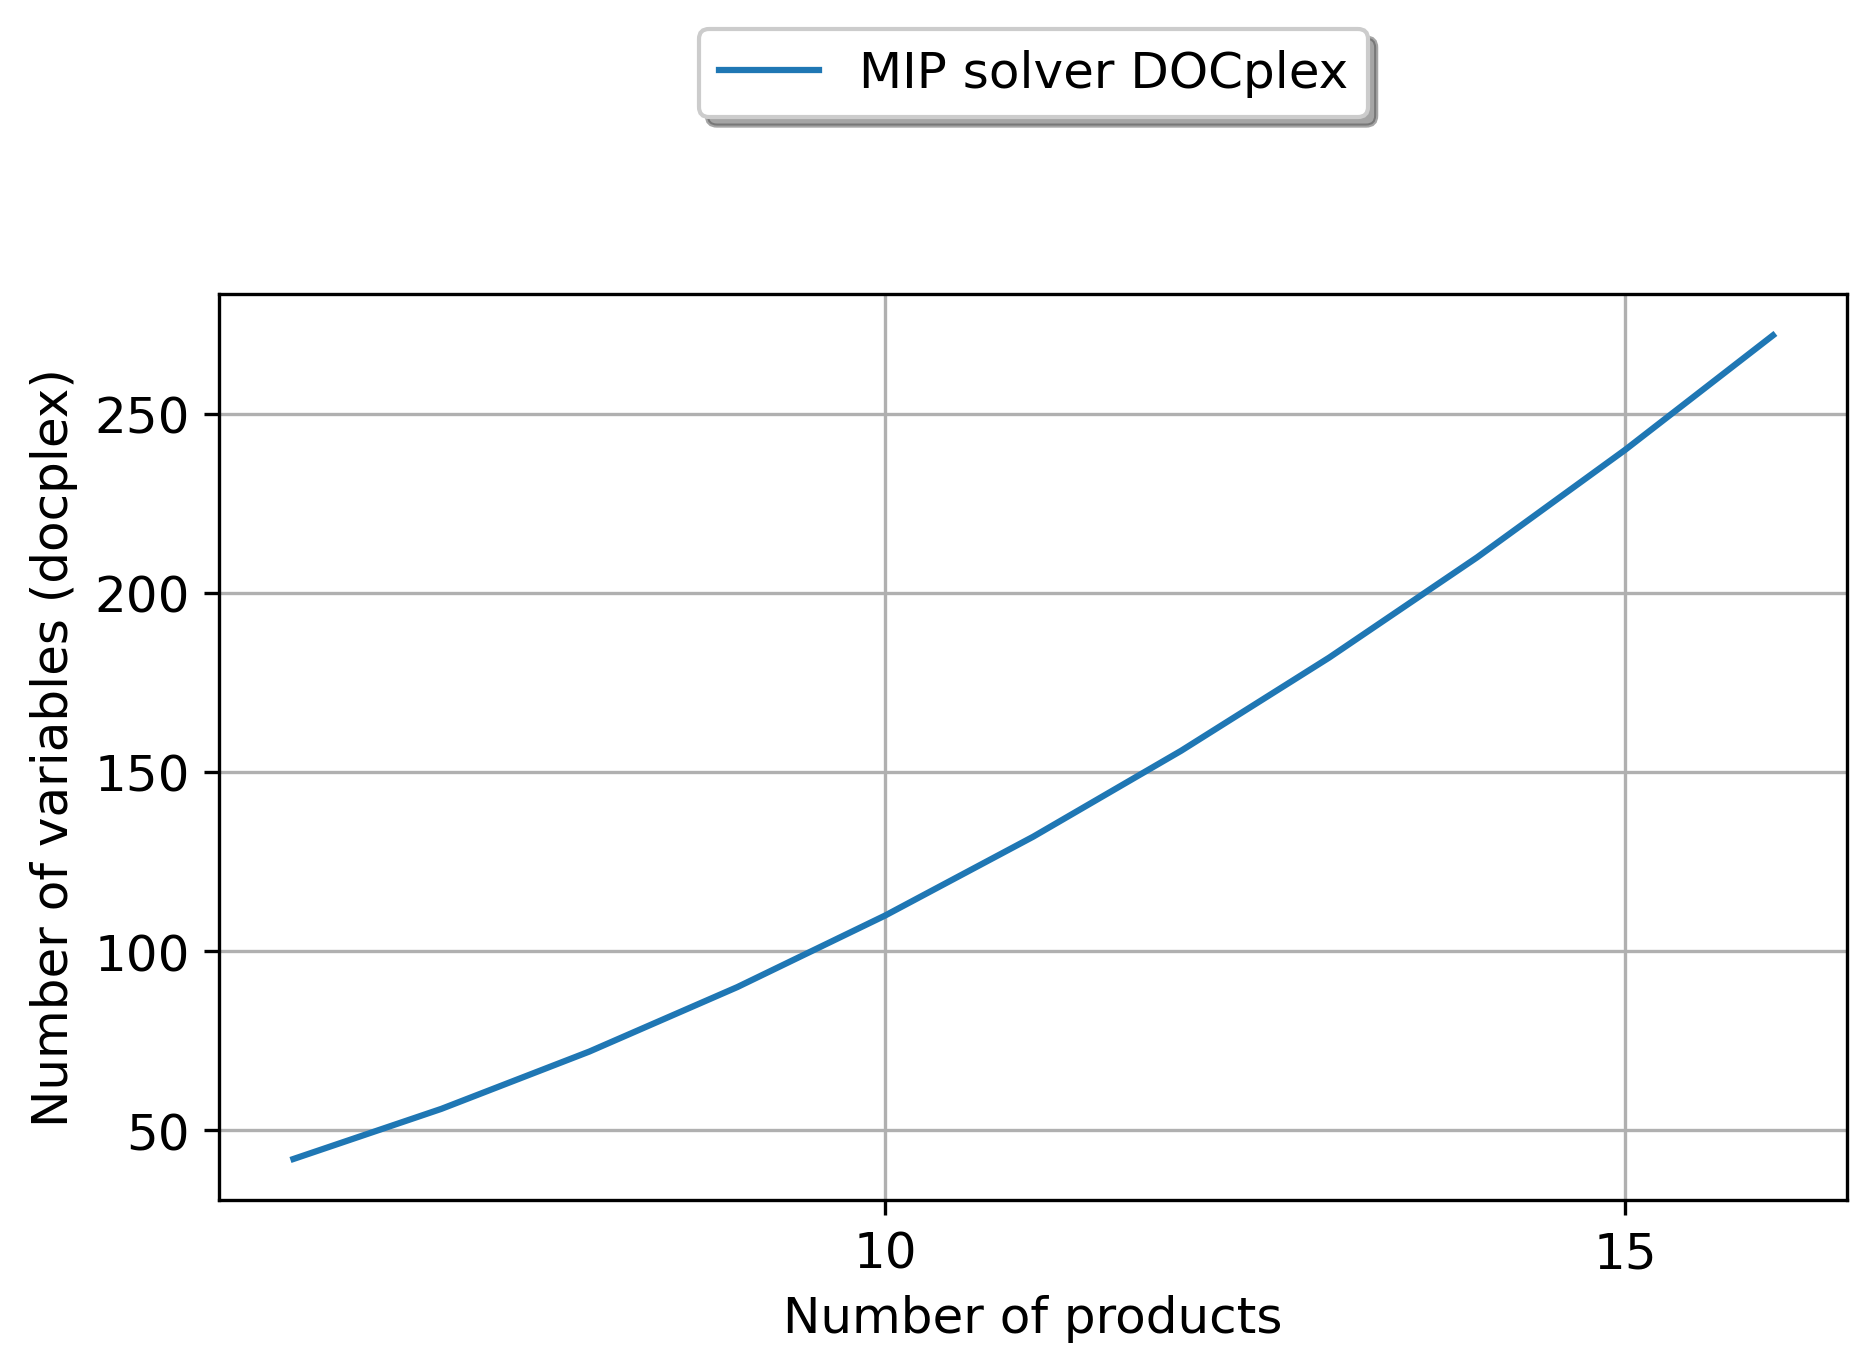

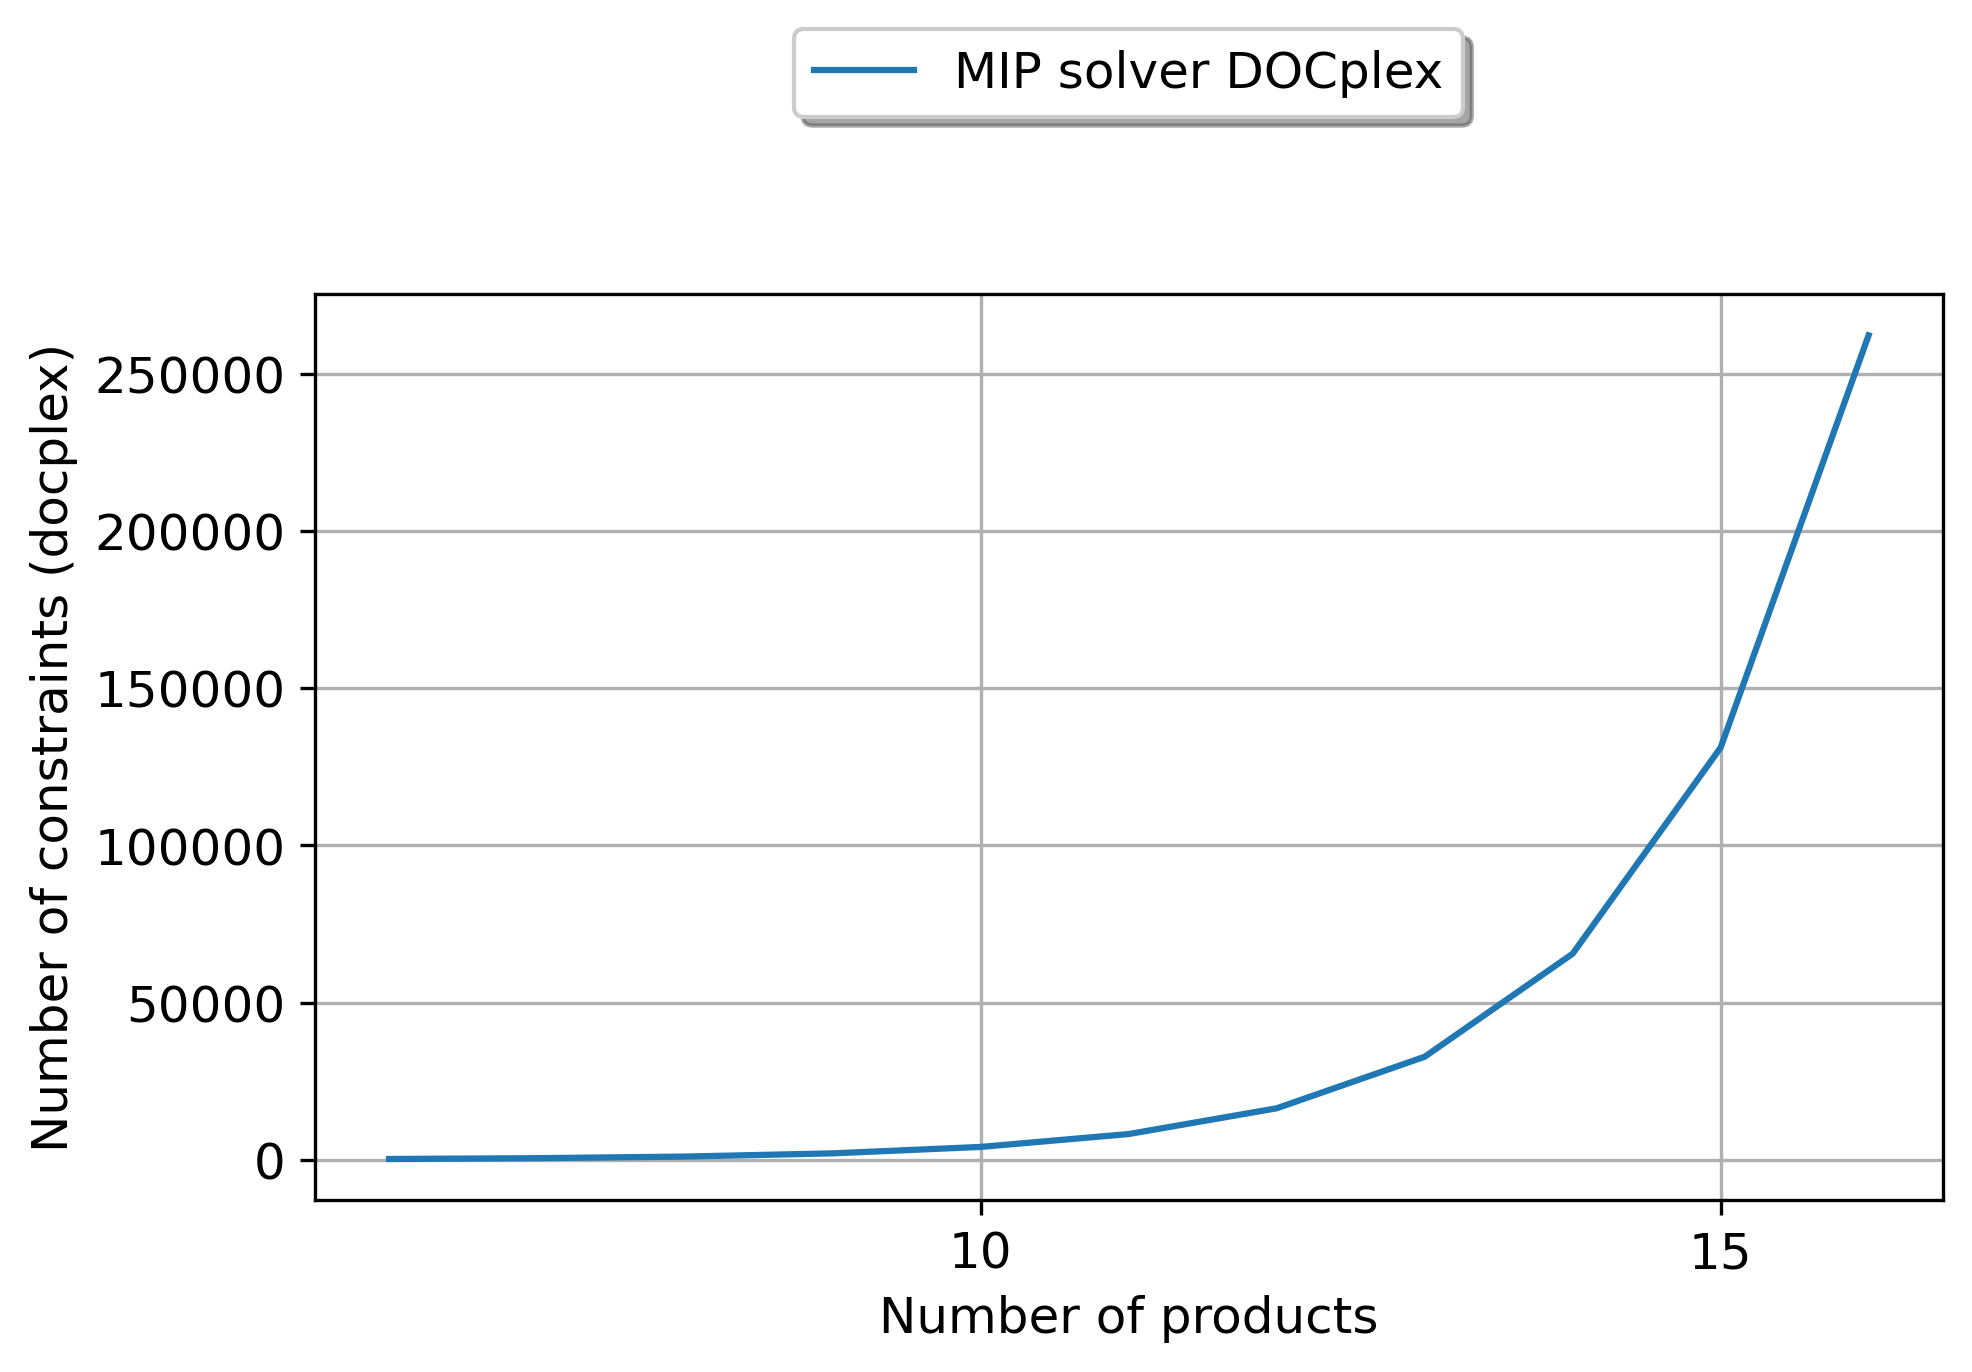

In [34]:
for metric, ylabel in metrics.items():
    plt.figure(figsize=(7, 4))
    plt.grid(True)
    # plt.title(f'Computational experiment (Metric {metric})', fontsize=12)
    plt.xticks(range(5, max(numProducts) + 1, 5), fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Number of products', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)

    for approach in approaches:
        # if approach == 'lp_normal':
        #     continue

        for consider_constraints in consider_constraints_options:
            if consider_constraints in [1, 3]:
                continue

            if len(data[approach][consider_constraints][metric]['numProducts']) > 0:
                plt.plot(
                    data[approach][consider_constraints][metric]['numProducts'],
                    data[approach][consider_constraints][metric]['means'],
                    # label=f'{approach}_{consider_constraints}')
                    # label=labels[consider_constraints])
                    # label=labels[approach][consider_constraints])
                    label=labels[approach])
                plt.fill_between(
                    data[approach][consider_constraints][metric]['numProducts'],
                    data[approach][consider_constraints][metric]['lbs'],
                    data[approach][consider_constraints][metric]['ubs'],
                    alpha=0.15)

    # plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.23), ncol=3, fancybox=True, shadow=True)
    plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.32), ncol=2, fancybox=True, shadow=True)

    if metric == 'Time':
        tikzplotlib.save(f'{results_file_option}.tex')
    plt.show()